# Edinburgh Modelling

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from scipy.stats import gaussian_kde
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import matplotlib.font_manager as fm
from matplotlib.patches import Patch
%config InlineBackend.figure_format = 'retina'
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
import xgboost as xgb
import shap
from scipy.spatial import cKDTree
from geo_northarrow import add_north_arrow
from matplotlib_scalebar.scalebar import ScaleBar
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from sklearn.preprocessing import StandardScaler
from PyGRF import PyGRF
from PyGRF import search_bandwidth
from PyGRF import PyGRFBuilder

# Load Cambria font
cambria_path = "/Library/Fonts/Microsoft/Cambria.ttf"  # Adjust path if needed
cambria_prop = fm.FontProperties(fname=cambria_path)

# Load modelling functions
import sys
sys.path.append('../../scripts')  # go up one folder, into scripts/

from modelling import (
    prepare_data,
    run_modelling_pipeline
)

## 1. Import Data

In [2]:
# Import data
edinburgh_airbnb = gpd.read_file('../../data/edinburgh/airbnb_per_edinburgh_glx.gpkg')
edinburgh_tourism_fs = gpd.read_file('../../data/edinburgh/edinburgh_glx_tourism_pois.gpkg')

In [3]:
# Merge the two datasets on glx_id keeping only one geometry column
edinburgh_airbnb_tourism_fs = edinburgh_tourism_fs.merge(edinburgh_airbnb, on='glx_id', how='left')

# Drop geometry_x and rename geometry_y to geometry
edinburgh_airbnb_tourism_fs.drop(columns=['geometry_x'], inplace=True)
edinburgh_airbnb_tourism_fs.rename(columns={'geometry_y': 'geometry'}, inplace=True)

In [4]:
# Create total_pois_log column
edinburgh_airbnb_tourism_fs['total_pois_log'] = np.log1p(edinburgh_airbnb_tourism_fs['total_pois'])

In [5]:
# Import Edinburgh GLX shapefile
edinburgh_glx = gpd.read_file("../../data/edinburgh/edinburgh_seamless.gpkg")
edinburgh_glx = edinburgh_glx.to_crs(epsg=27700)

## 2. Data Exploration

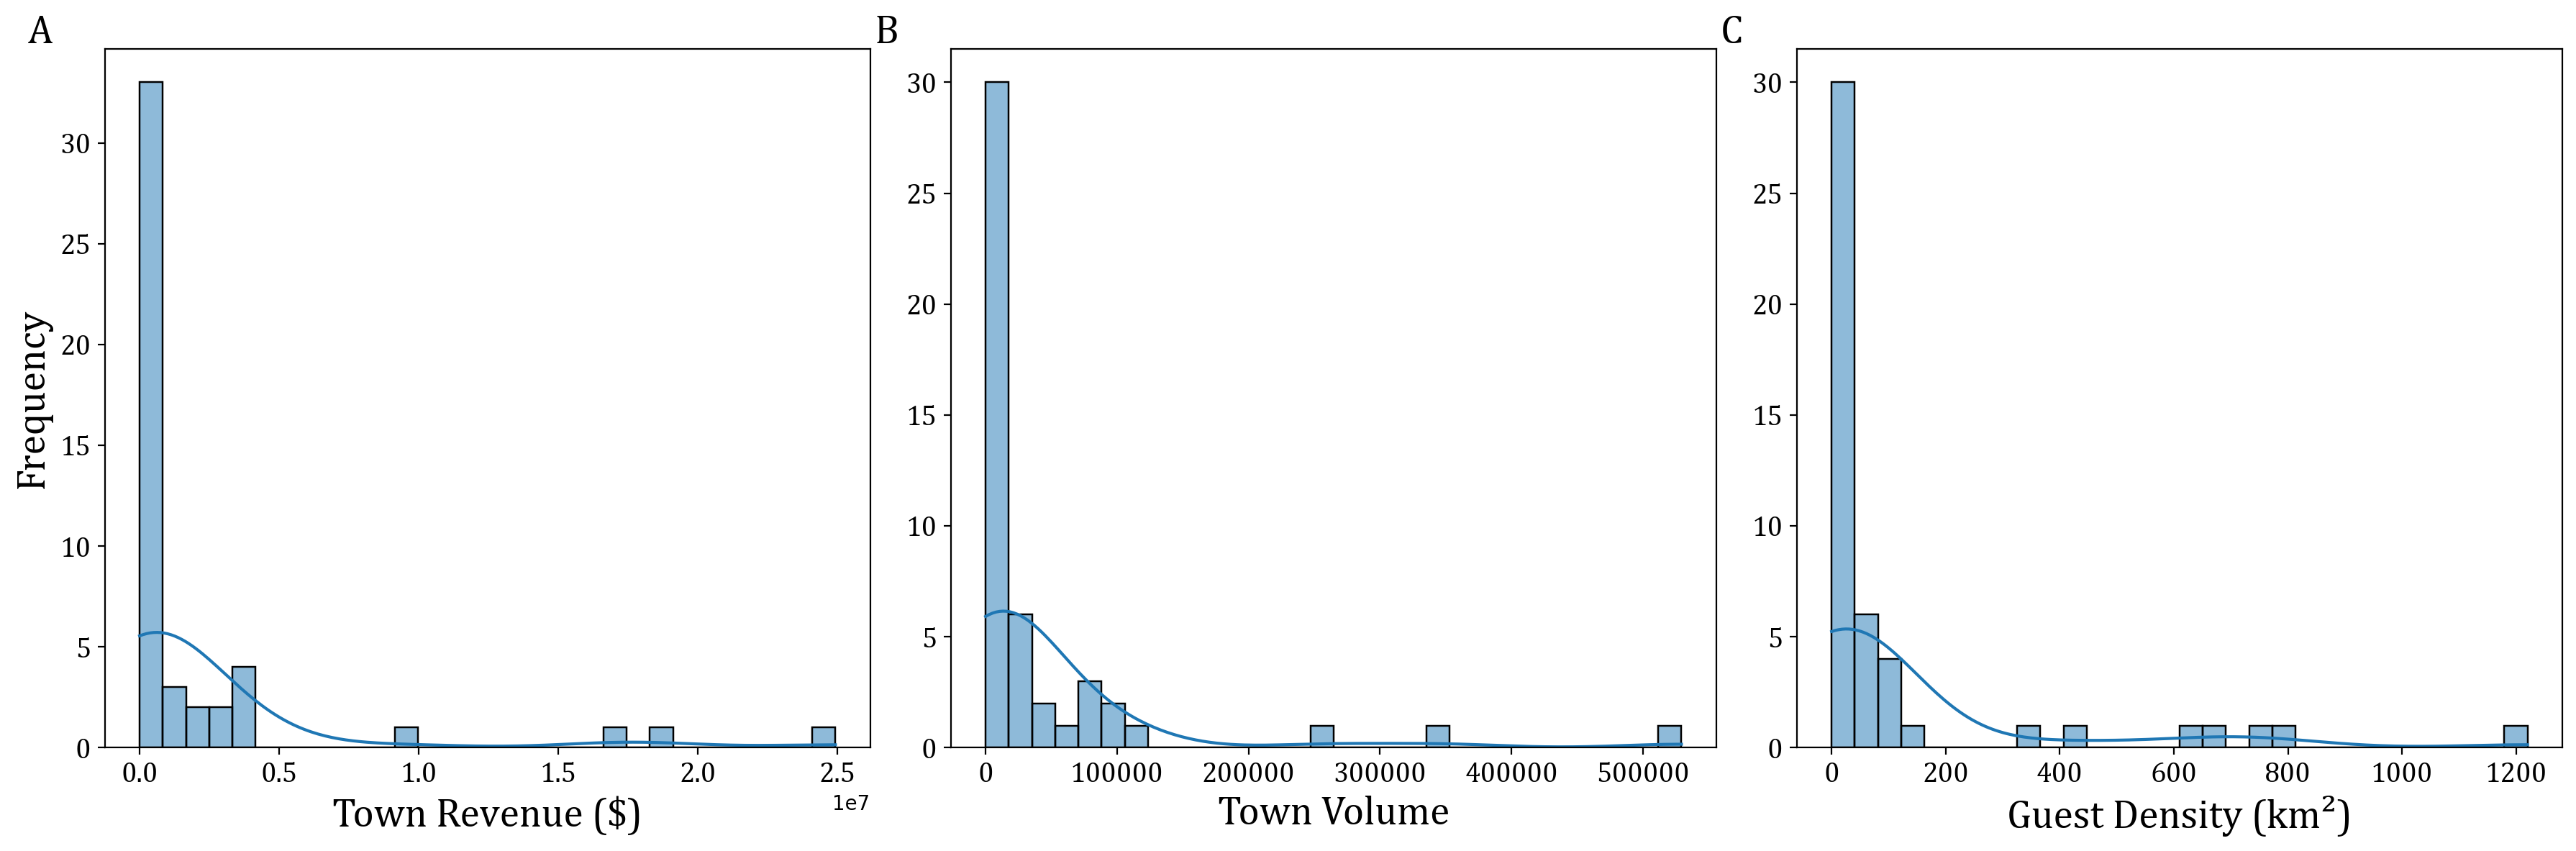

In [6]:
# Create plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Total Revenue
sns.histplot(edinburgh_airbnb_tourism_fs['total_revenue'], bins=30, kde=True, ax=axes[0])
axes[0].set_xlabel('Town Revenue ($)', fontproperties=cambria_prop, size=20)
axes[0].set_ylabel('Frequency', fontproperties=cambria_prop, size=20)

# Plot 2: Total Volume
sns.histplot(edinburgh_airbnb_tourism_fs['total_volume'], bins=30, kde=True, ax=axes[1])
axes[1].set_xlabel('Town Volume', fontproperties=cambria_prop, size=20)
axes[1].set_ylabel('', fontproperties=cambria_prop)

# Plot 3: Tourism Intensity
sns.histplot(edinburgh_airbnb_tourism_fs['total_tourism_intensity_km2'], bins=30, kde=True, ax=axes[2])
axes[2].set_xlabel('Guest Density (km²)', fontproperties=cambria_prop, size=20)
axes[2].set_ylabel('', fontproperties=cambria_prop)

# Add A–C panel tags
panel_labels = ['A', 'B', 'C']
for i, ax in enumerate(axes):
    ax.text(
        -0.1, 1.05,
        panel_labels[i],
        transform=ax.transAxes,
        fontsize=20,
        fontproperties=cambria_prop,
        fontweight='bold',
        va='top',
        ha='left'
    ),
    ax.grid(False)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontproperties(cambria_prop)
        label.set_fontsize(14)

plt.tight_layout()
plt.savefig('../../results/edinburgh/airbnb_feature_histograms.png', dpi=500, bbox_inches='tight')
plt.show()

In [7]:
# Define the non-logged features
features = [
    'air_travel_density',
    'arts_other_density',
    'bars_nightlife_density',
    'cafes_bakeries_density',
    'cultural_institution_density',
    'dining_other_density',
    'entertainment_nightlife_density',
    'event_space_density',
    'fast_food_density',
    'food_drink_production_density',
    'full_service_restaurant_density',
    'high_end_dining_density',
    'historic_landmark_density',
    'leisure_activity_centre_density',
    'local_public_transit_density',
    'lodging_density',
    'major_attraction_density',
    'major_transit_hub_density',
    'mobility_services_density',
    'music_cinema_venue_density',
    'nature_trail_density',
    'outdoors_other_density',
    'park_garden_density',
    'public_art_density',
    'public_plaza_square_density',
    'retail_books_hobbies_density',
    'retail_fashion_apparel_density',
    'retail_food_beverage_density',
    'retail_gifts_misc_density',
    'retail_health_beauty_density',
    'retail_home_electronics_density',
    'retail_luxury_density',
    'retail_markets_plazas_density',
    'retail_other_density',
    'rural_agricultural_density',
    'tourism_services_density',
    'transport_infrastructure_density',
    'travel_other_density',
    'waterfront_river_density'
    ]

# Define the logged features
features_logged = [
    'air_travel_density_log',
    'arts_other_density_log',
    'bars_nightlife_density_log',
    'cafes_bakeries_density_log',
    'cultural_institution_density_log',
    'dining_other_density_log',
    'entertainment_nightlife_density_log',
    'event_space_density_log',
    'fast_food_density_log',
    'food_drink_production_density_log',
    'full_service_restaurant_density_log',
    'high_end_dining_density_log',
    'historic_landmark_density_log',
    'leisure_activity_centre_density_log',
    'local_public_transit_density_log',
    'lodging_density_log',
    'major_attraction_density_log',
    'major_transit_hub_density_log',
    'mobility_services_density_log',
    'music_cinema_venue_density_log',
    'nature_trail_density_log',
    'outdoors_other_density_log',
    'park_garden_density_log',
    'public_art_density_log',
    'public_plaza_square_density_log',
    'retail_books_hobbies_density_log',
    'retail_fashion_apparel_density_log',
    'retail_food_beverage_density_log',
    'retail_gifts_misc_density_log',
    'retail_health_beauty_density_log',
    'retail_home_electronics_density_log',
    'retail_luxury_density_log',
    'retail_markets_plazas_density_log',
    'retail_other_density_log',
    'rural_agricultural_density_log',
    'tourism_services_density_log',
    'transport_infrastructure_density_log',
    'travel_other_density_log',
    'waterfront_river_density_log'
]

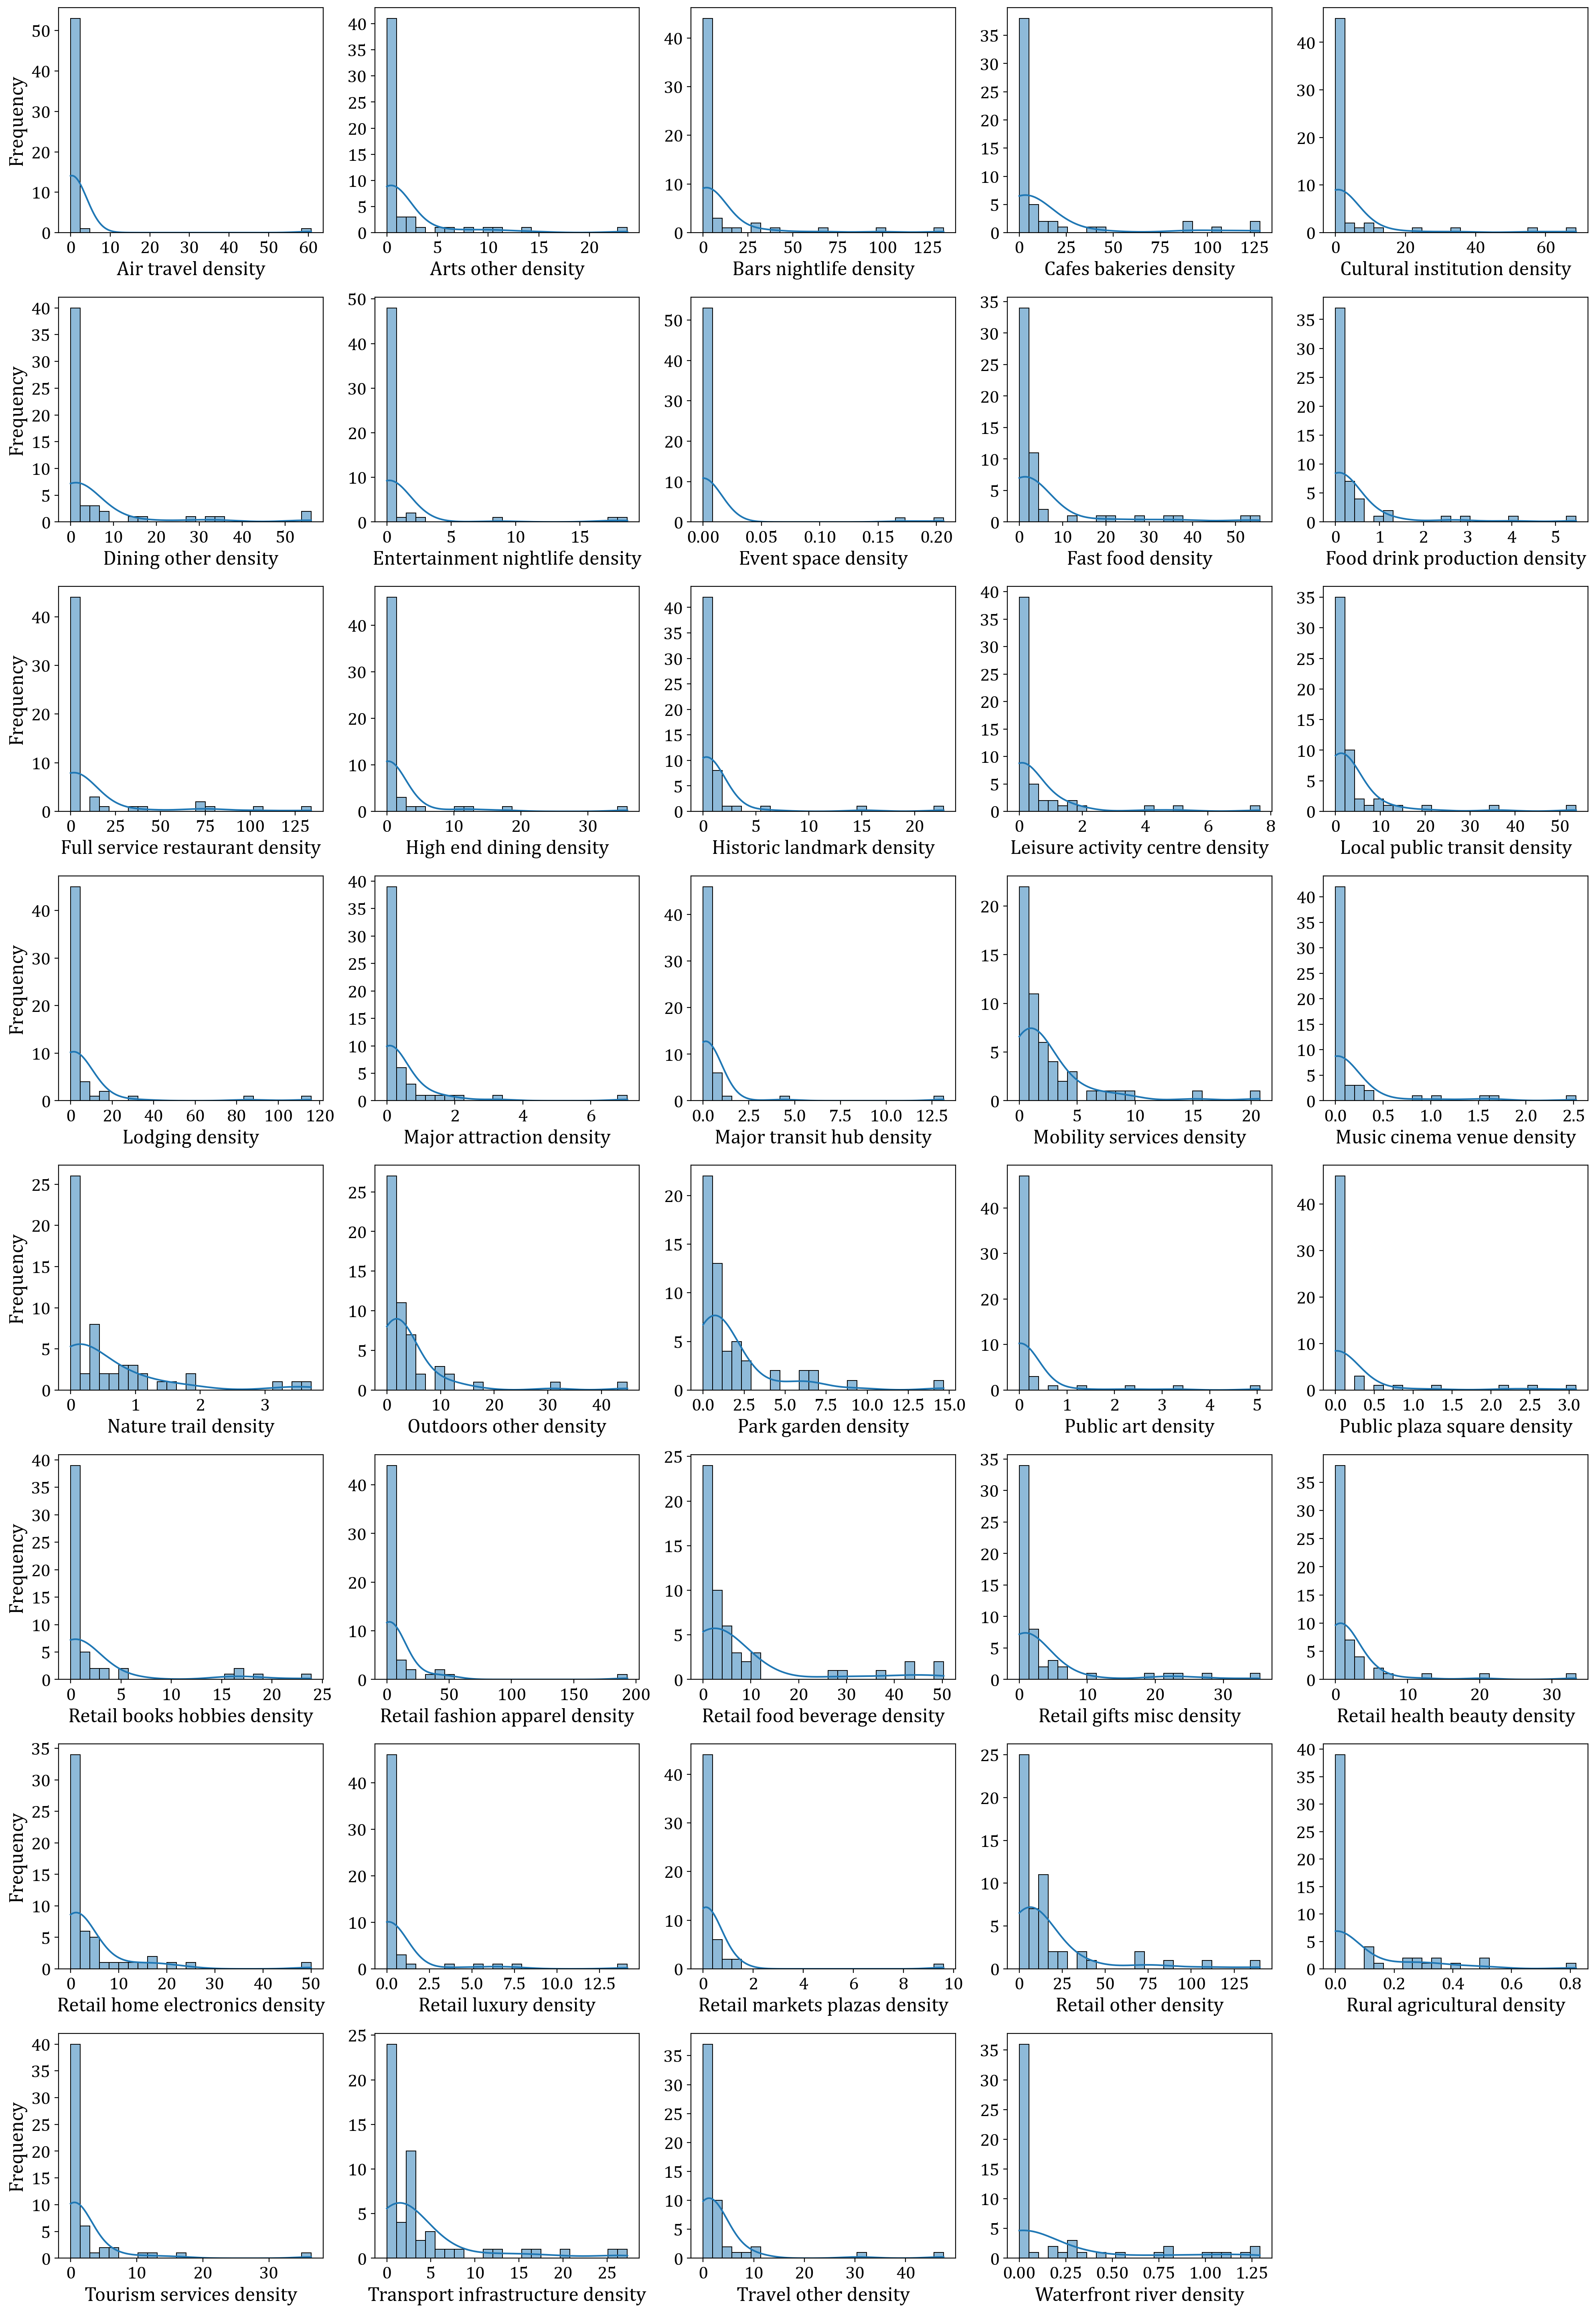

In [ ]:
# For all features, create histograms to check for normality
n_rows, n_cols = 14, 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 50))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.histplot(edinburgh_airbnb_tourism_fs[feature], bins=25, kde=True, ax=axes[i])
    axes[i].set_xlabel(
        axes[i].get_xlabel().replace('_', ' ').replace('density', 'Density').capitalize(),
        fontproperties=cambria_prop, size=18
    )

    # Only show y-axis label on first column of each row
    if i % n_cols == 0:
        axes[i].set_ylabel('Frequency', fontproperties=cambria_prop, size = 18)
    else:
        axes[i].set_ylabel('')  # Remove y-axis label

    axes[i].grid(False)

    # Set font for tick labels
    for label in axes[i].get_xticklabels() + axes[i].get_yticklabels():
        label.set_fontproperties(cambria_prop)
        label.set_fontsize(16)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('../../results/edinburgh/feature_histograms.png', dpi=500, bbox_inches='tight')
plt.show()

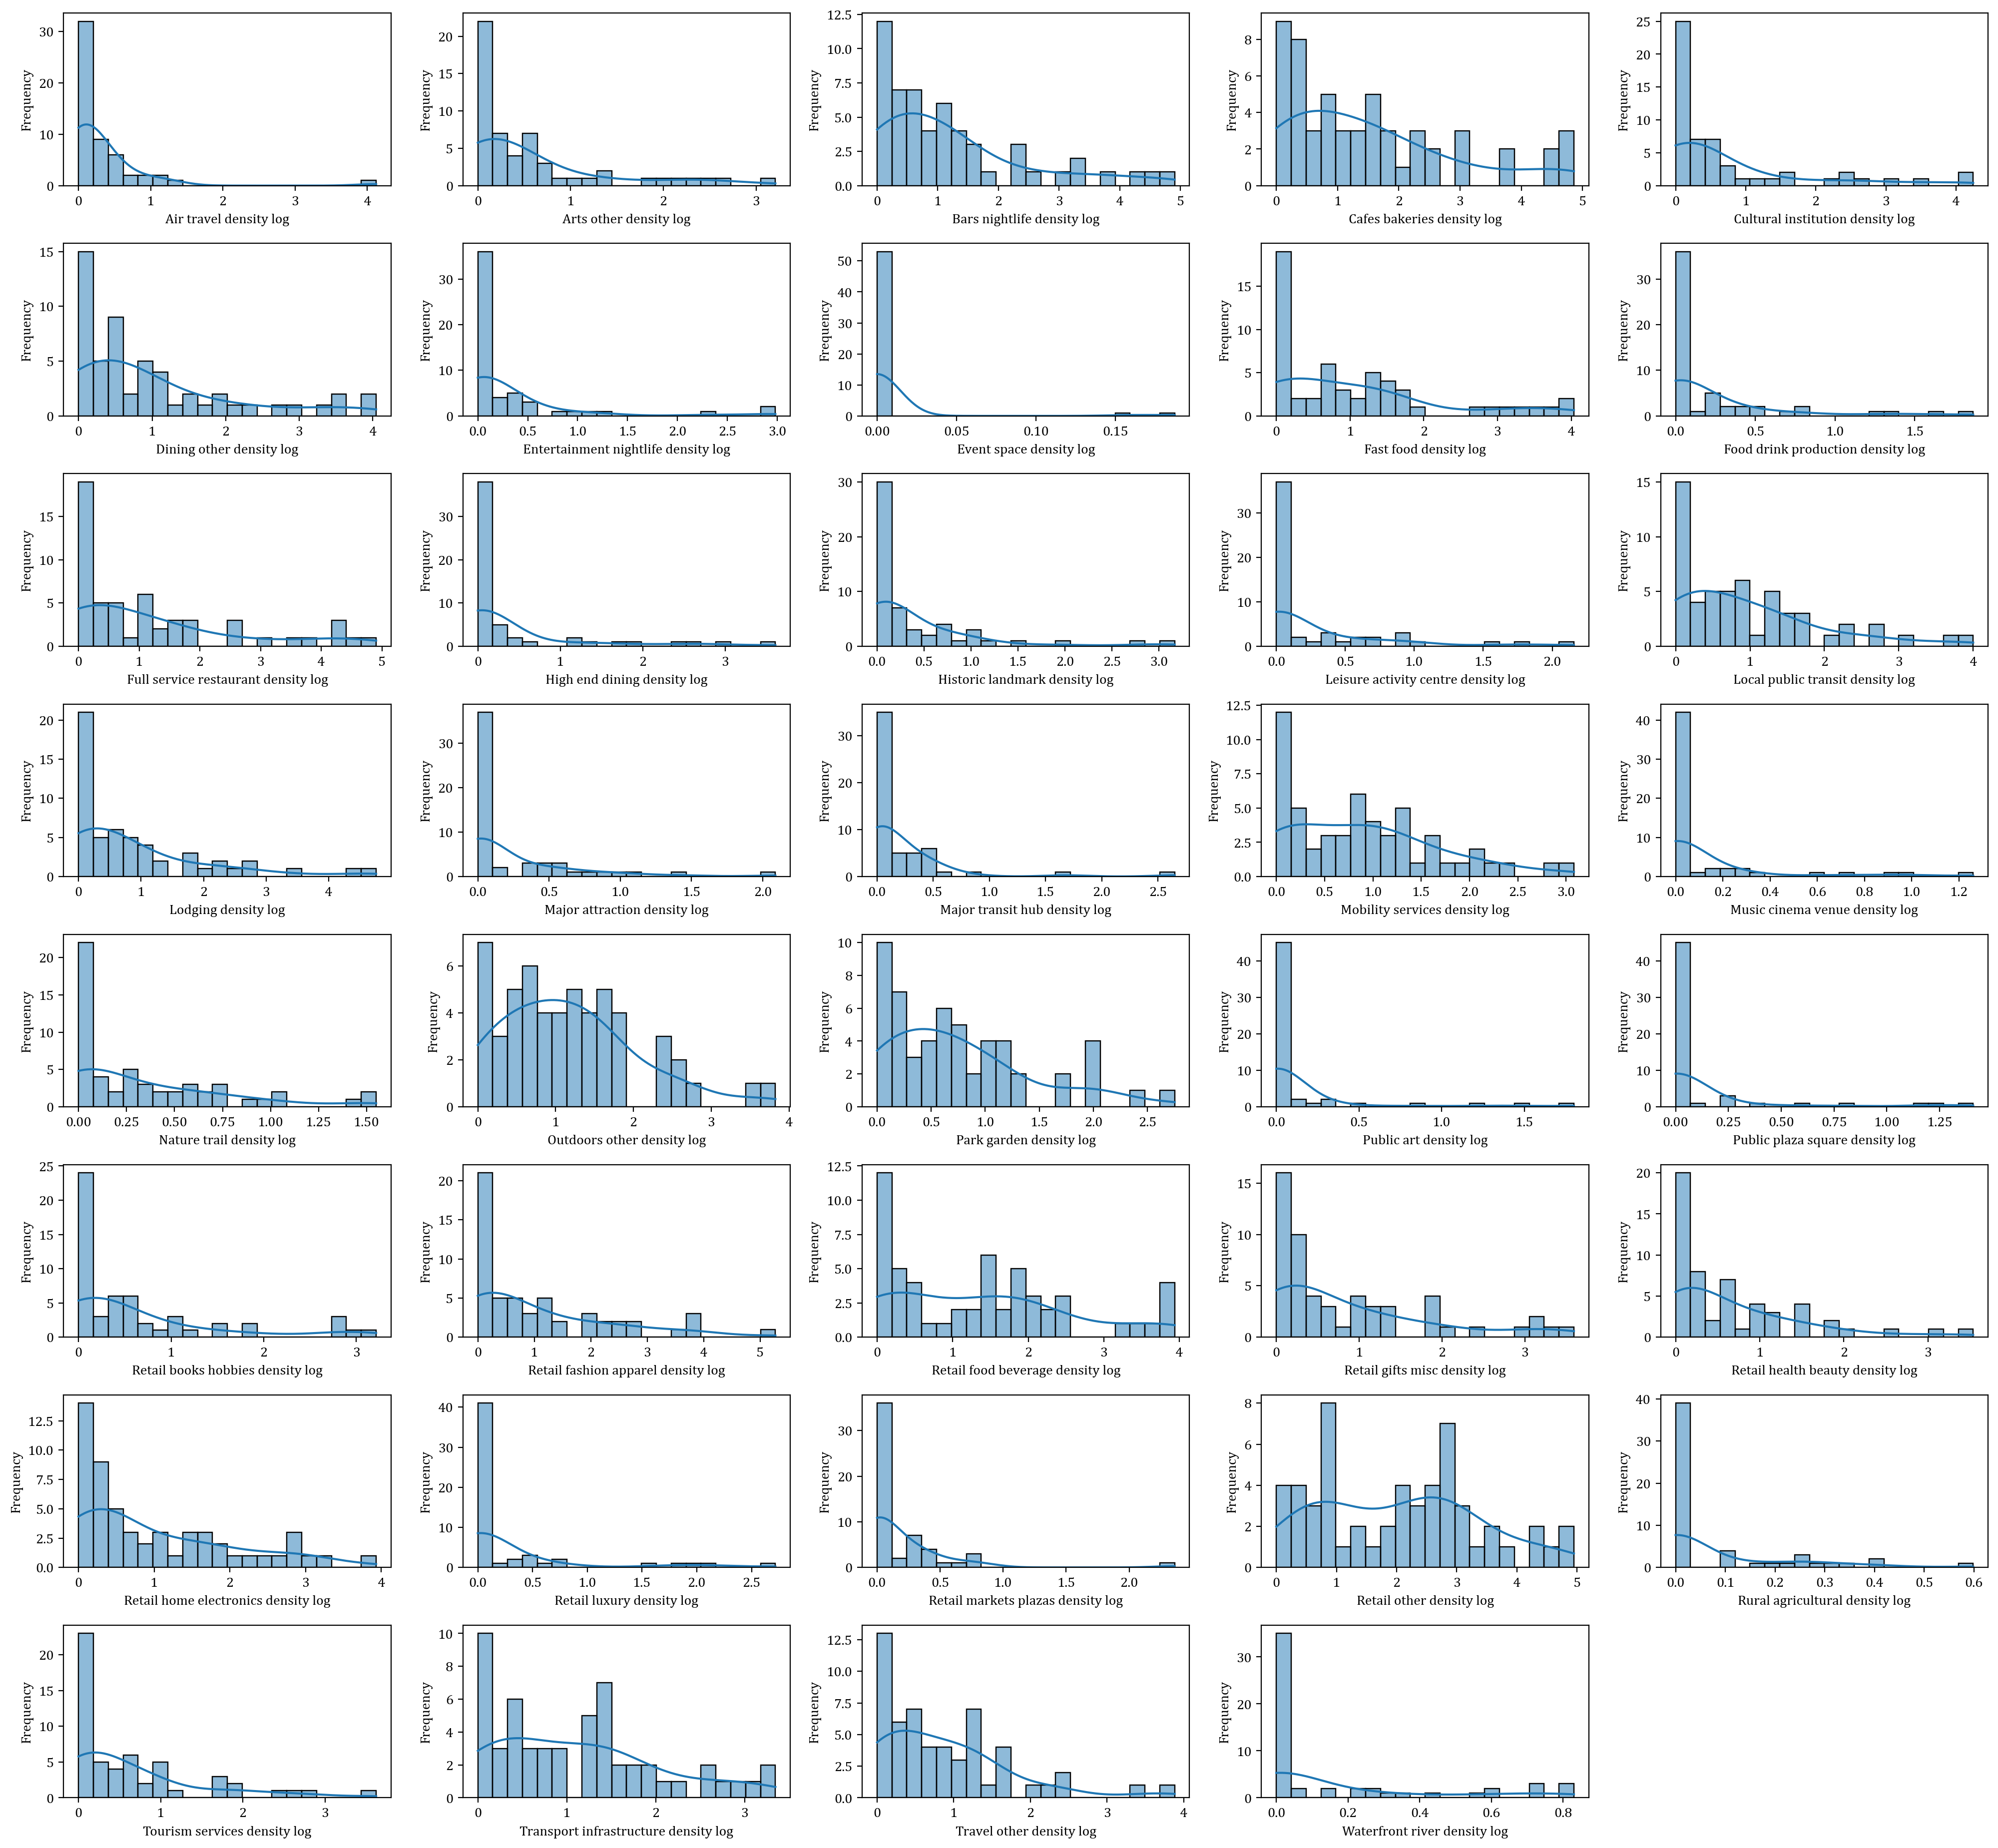

In [ ]:
# For all features, create histograms to check for normality
fig, axes = plt.subplots(14, 5, figsize=(20, 32))
axes = axes.flatten()
for i, feature in enumerate(features_logged):
    sns.histplot(edinburgh_airbnb_tourism_fs[feature], bins=20, kde=True, ax=axes[i])
    axes[i].set_xlabel(axes[i].get_xlabel().replace('_', ' ').replace('density_log', 'Density (per km²) (log)').capitalize(), fontproperties=cambria_prop)
    axes[i].set_ylabel('Frequency', fontproperties=cambria_prop)
    axes[i].grid(False)
    for label in axes[i].get_xticklabels() + axes[i].get_yticklabels():
        label.set_fontproperties(cambria_prop)
# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show();

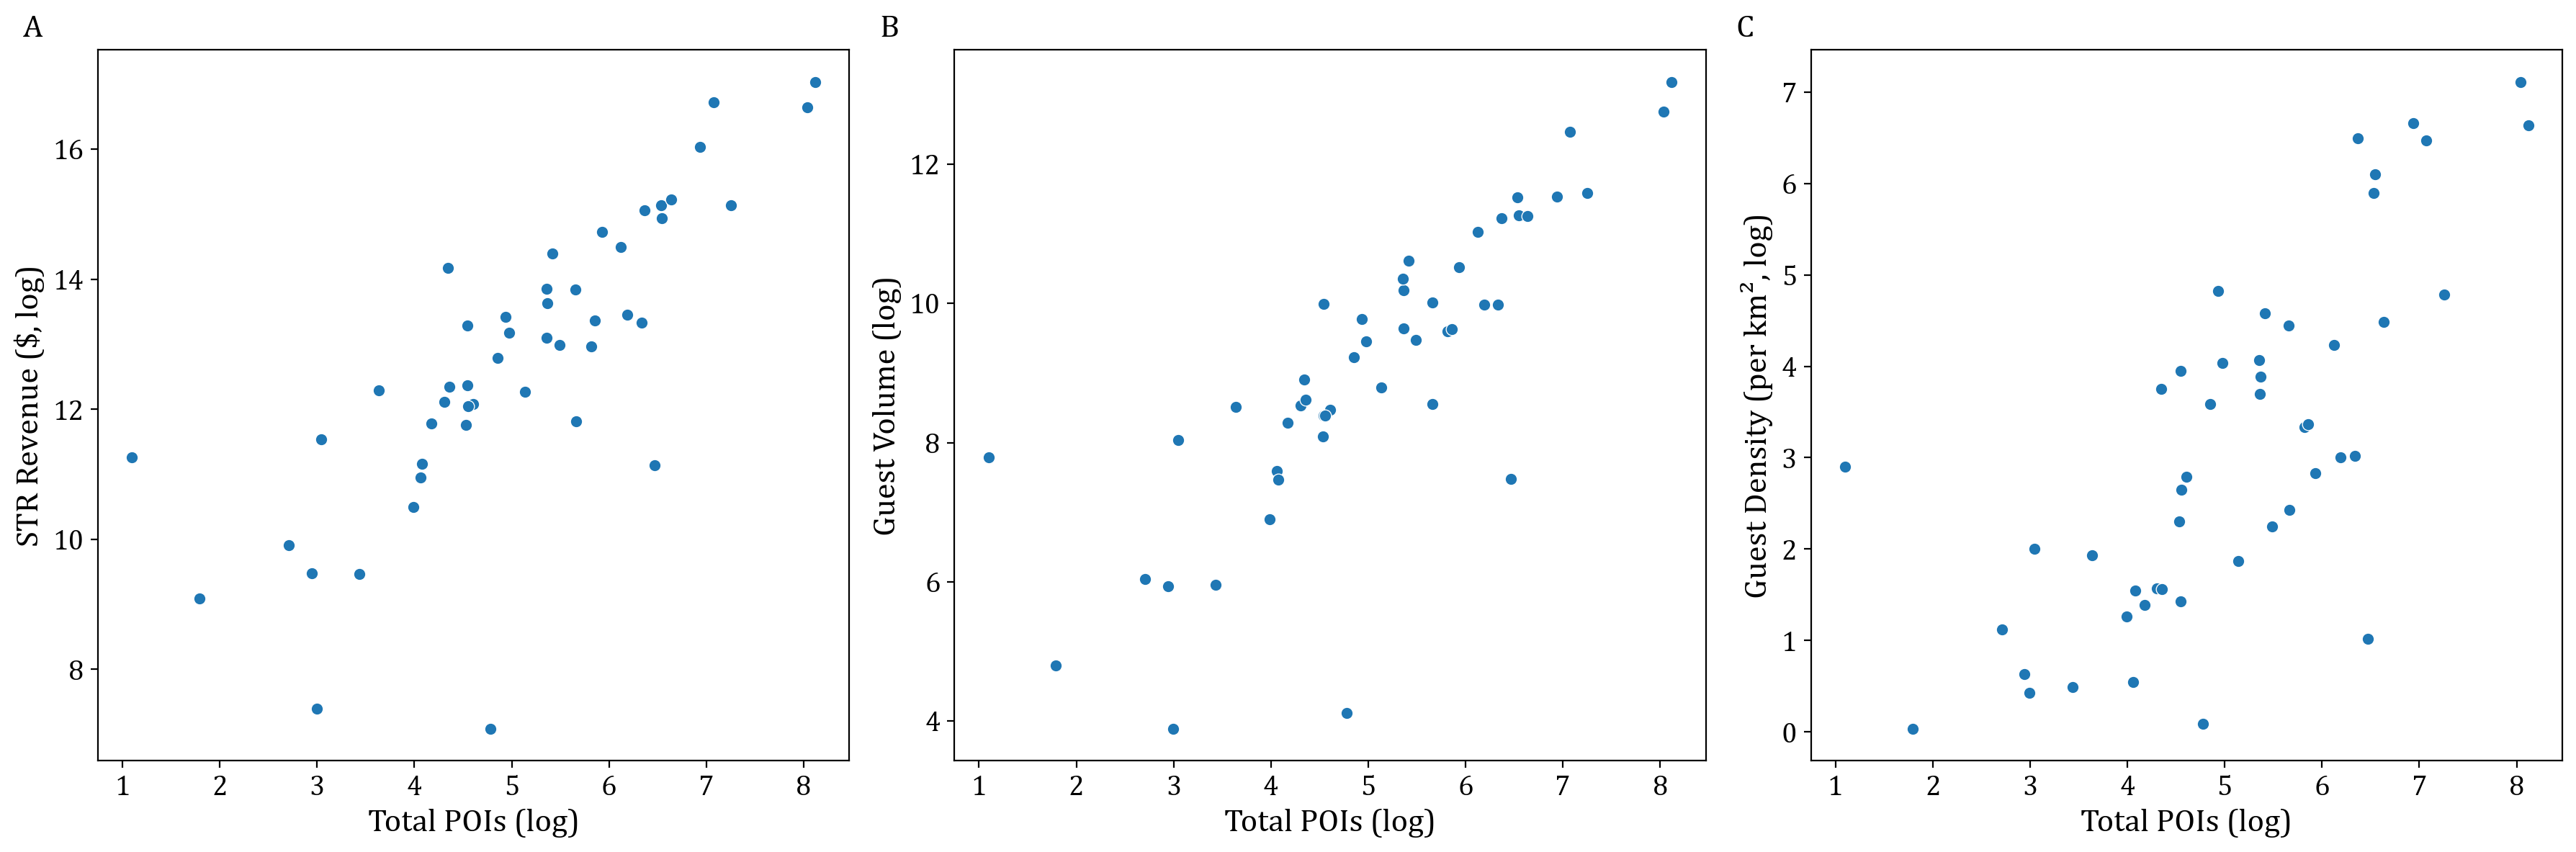

In [9]:
# Create three scatter plots showing total_pois vs, total_volume, total_revenue, and total_tourism_intensity_km2
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.scatterplot(data=edinburgh_airbnb_tourism_fs, x='total_pois_log', y='total_revenue_log', ax=axes[0])
axes[0].set_xlabel('Total POIs (log)', fontproperties=cambria_prop, size=16)
axes[0].set_ylabel('STR Revenue ($, log)', fontproperties=cambria_prop, size=16)

sns.scatterplot(data=edinburgh_airbnb_tourism_fs, x='total_pois_log', y='total_volume_log', ax=axes[1])
axes[1].set_xlabel('Total POIs (log)', fontproperties=cambria_prop, size=16)
axes[1].set_ylabel('Guest Volume (log)', fontproperties=cambria_prop, size=16)

sns.scatterplot(data=edinburgh_airbnb_tourism_fs, x='total_pois_log', y='total_tourism_intensity_km2_log', ax=axes[2])
axes[2].set_xlabel('Total POIs (log)', fontproperties=cambria_prop, size=16)
axes[2].set_ylabel('Guest Density (per km², log)', fontproperties=cambria_prop, size=16)

# Add A–C panel tags
panel_labels = ['A', 'B', 'C']
for i, ax in enumerate(axes):
    ax.text(
        -0.1, 1.05,
        panel_labels[i],
        transform=ax.transAxes,
        fontsize=16,
        fontproperties=cambria_prop,
        fontweight='bold',
        va='top',
        ha='left'
    ),
    ax.grid(False)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontproperties(cambria_prop)
        label.set_fontsize(14)

plt.tight_layout()
plt.savefig('../../results/edinburgh/targets_poi_scatters.png', dpi=300, bbox_inches='tight')
plt.show()


In [10]:
# Calculate pearson's correlation coefficients for total_pois_log vs total_volume_log, total_revenue_log, and total_tourism_intensity_km2_log
total_pois_volume_corr = edinburgh_airbnb_tourism_fs['total_pois_log'].corr(edinburgh_airbnb_tourism_fs['total_volume_log'])
total_pois_revenue_corr = edinburgh_airbnb_tourism_fs['total_pois_log'].corr(edinburgh_airbnb_tourism_fs['total_revenue_log'])
total_pois_tourism_corr = edinburgh_airbnb_tourism_fs['total_pois_log'].corr(edinburgh_airbnb_tourism_fs['total_tourism_intensity_km2_log']) 
print(f"Total POIs vs Total Volume (log): {total_pois_volume_corr:.2f}")
print(f"Total POIs vs Total Revenue (log): {total_pois_revenue_corr:.2f}")
print(f"Total POIs vs Total Tourism Intensity (km²) (log): {total_pois_tourism_corr:.2f}")

Total POIs vs Total Volume (log): 0.81
Total POIs vs Total Revenue (log): 0.79
Total POIs vs Total Tourism Intensity (km²) (log): 0.74


In [11]:
# Calculate the total poi density
edinburgh_airbnb_tourism_fs['total_poi_density'] = edinburgh_airbnb_tourism_fs['total_pois'] / edinburgh_airbnb_tourism_fs['area_km2']
# Calculate the total poi density log
edinburgh_airbnb_tourism_fs['total_poi_density_log'] = np.log1p(edinburgh_airbnb_tourism_fs['total_poi_density'])

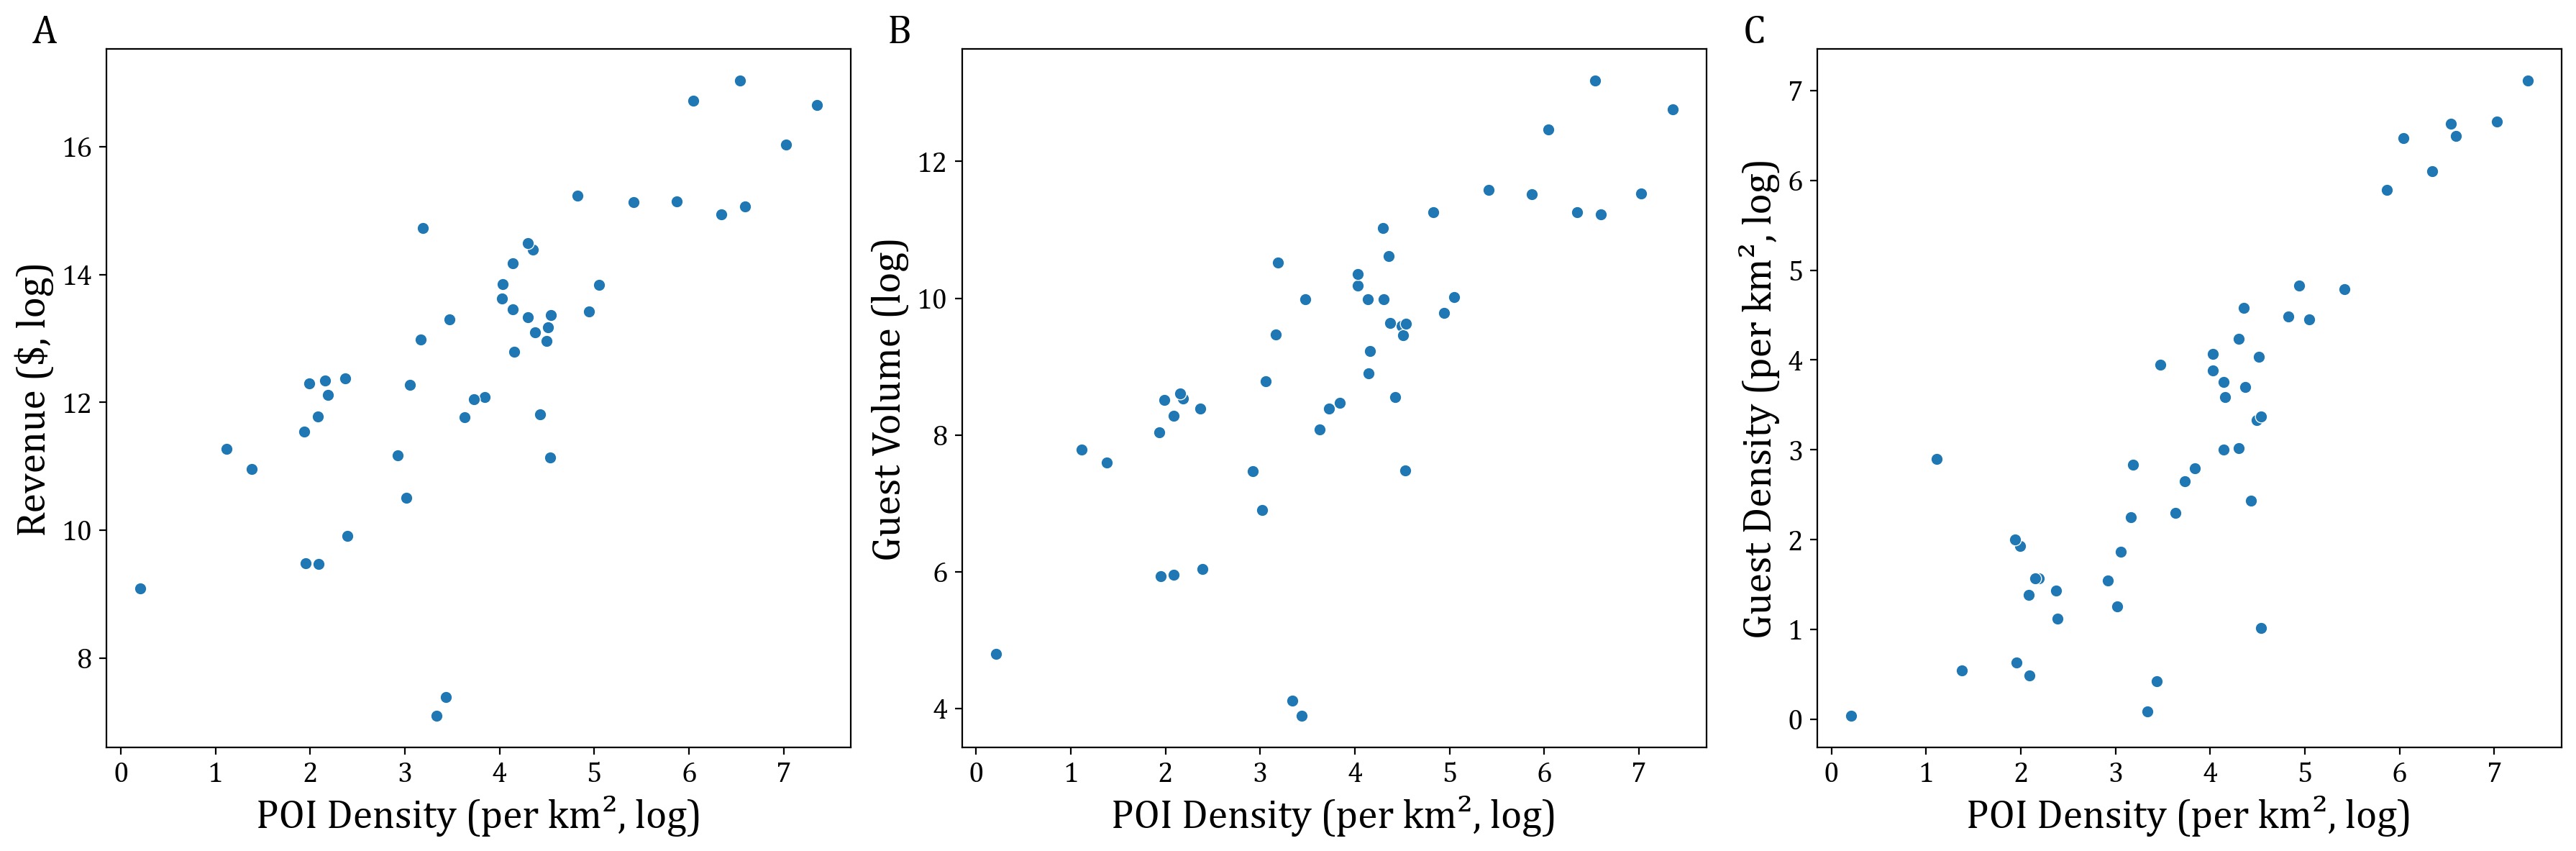

In [12]:
# Create three scatter plots showing total_pois vs, total_volume, total_revenue, and total_tourism_intensity_km2
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.scatterplot(data=edinburgh_airbnb_tourism_fs, x='total_poi_density_log', y='total_revenue_log', ax=axes[0])
axes[0].set_xlabel('POI Density (per km², log)', fontproperties=cambria_prop, size = 20)
axes[0].set_ylabel('Revenue ($, log)', fontproperties=cambria_prop, size = 20)

sns.scatterplot(data=edinburgh_airbnb_tourism_fs, x='total_poi_density_log', y='total_volume_log', ax=axes[1])
axes[1].set_xlabel('POI Density (per km², log)', fontproperties=cambria_prop, size = 20)
axes[1].set_ylabel('Guest Volume (log)', fontproperties=cambria_prop, size = 20)

sns.scatterplot(data=edinburgh_airbnb_tourism_fs, x='total_poi_density_log', y='total_tourism_intensity_km2_log', ax=axes[2])
axes[2].set_xlabel('POI Density (per km², log)', fontproperties=cambria_prop, size = 20)
axes[2].set_ylabel('Guest Density (per km², log)', fontproperties=cambria_prop, size = 20)

# Add A–C panel tags
panel_labels = ['A', 'B', 'C']
for i, ax in enumerate(axes):
    ax.text(
        -0.1, 1.05,
        panel_labels[i],
        transform=ax.transAxes,
        fontsize=20,
        fontproperties=cambria_prop,
        fontweight='bold',
        va='top',
        ha='left'
    ),
    ax.grid(False)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontproperties(cambria_prop)
        label.set_fontsize(14)

plt.tight_layout()
plt.savefig('../../results/edinburgh/targets_poi_scatters.png', dpi=500, bbox_inches='tight')
plt.show()


In [13]:
# Calculate pearson's correlation coefficients for total_pois_density_log vs total_volume_log, total_revenue_log, and total_tourism_intensity_km2_log
total_pois_volume_corr = edinburgh_airbnb_tourism_fs['total_poi_density_log'].corr(edinburgh_airbnb_tourism_fs['total_volume_log'])
total_pois_revenue_corr = edinburgh_airbnb_tourism_fs['total_poi_density_log'].corr(edinburgh_airbnb_tourism_fs['total_revenue_log'])
total_pois_tourism_corr = edinburgh_airbnb_tourism_fs['total_poi_density_log'].corr(edinburgh_airbnb_tourism_fs['total_tourism_intensity_km2_log']) 
print(f"Density of POIs vs Total Volume (log): {total_pois_volume_corr:.2f}")
print(f"Density of POIs vs Total Revenue (log): {total_pois_revenue_corr:.2f}")
print(f"Density of POIs vs Total Tourism Intensity (km²) (log): {total_pois_tourism_corr:.2f}")

Density of POIs vs Total Volume (log): 0.75
Density of POIs vs Total Revenue (log): 0.75
Density of POIs vs Total Tourism Intensity (km²) (log): 0.87


## 3. Random Forest
### Total Revenue

Analysing: Total Revenue ($)
Data prepared for target: 'total_revenue_log'
Number of features: 39
Number of rows after cleaning: 48

--- Training Baseline Model ---
Baseline R-squared (R²): 0.63
Baseline MAE (log): 1.315
Baseline RMSE (log): 1.460
Baseline MAE (original): 5,436,946.44
Baseline RMSE (original): 9,338,784.42

--- Starting Hyperparameter Tuning ---
Tuning complete.
Best parameters found: {'n_estimators': 300, 'min_samples_leaf': 4, 'max_features': 1.0, 'max_depth': None}
Tuned R-squared (R²): 0.50
Tuned MAE (log): 1.546
Tuned RMSE (log): 1.710
Tuned MAE (original): 5,805,513.08
Tuned RMSE (original): 9,907,901.88


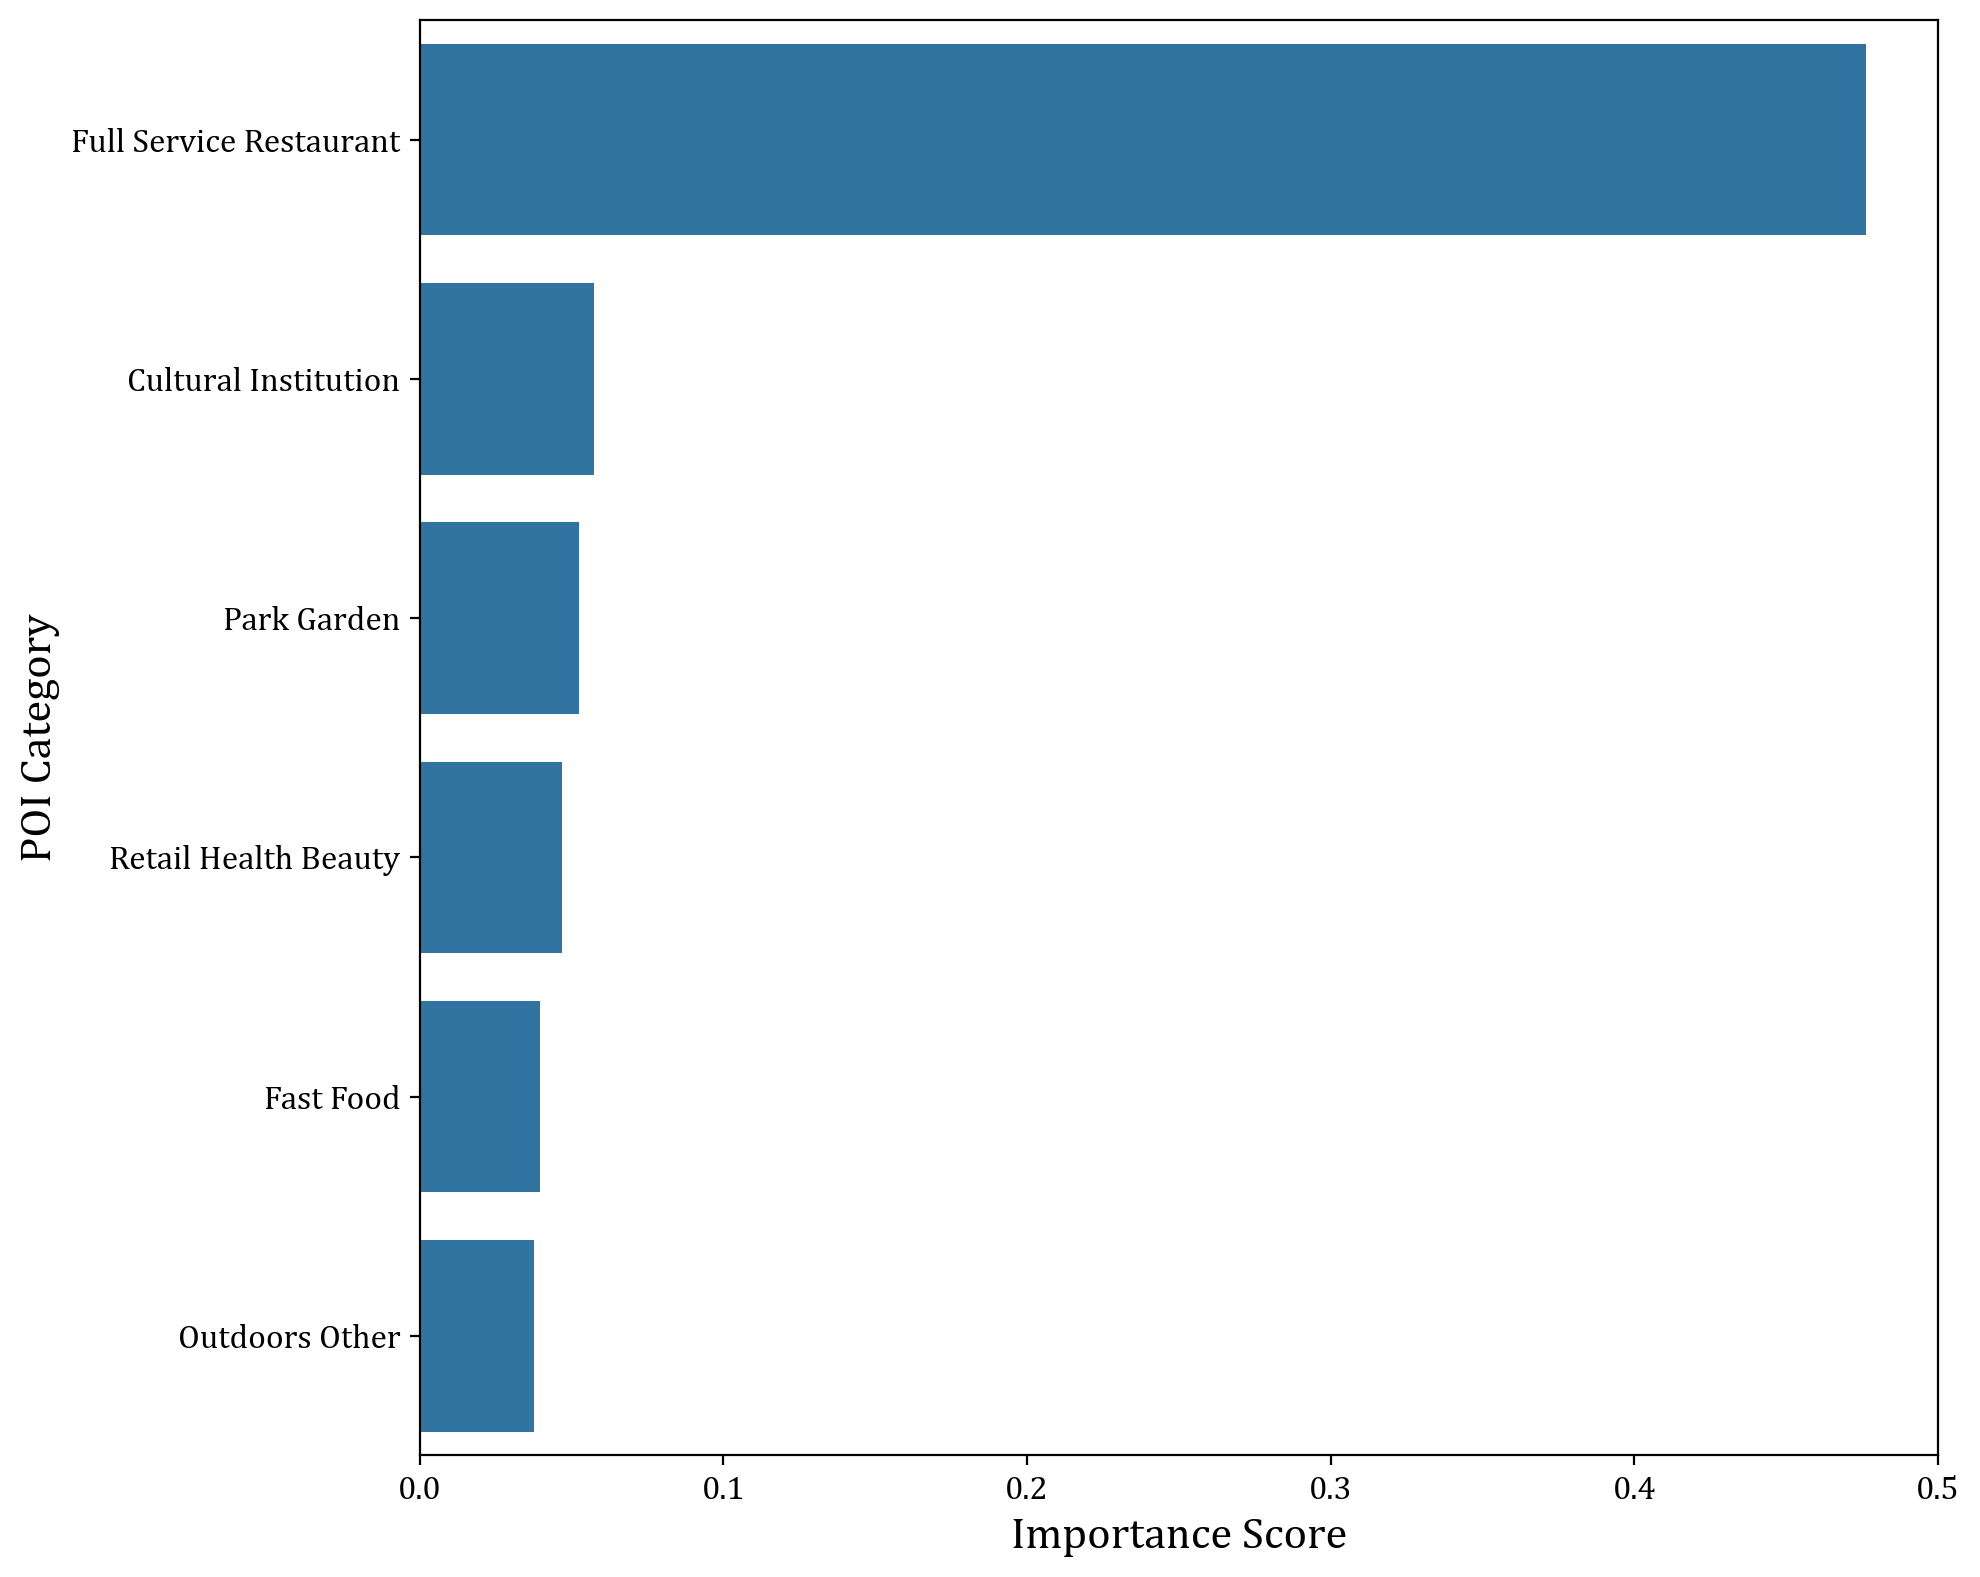


--- Top 6 Most Important Features ---
full_service_restaurant_density_log    0.476223
cultural_institution_density_log       0.057359
park_garden_density_log                0.052513
retail_health_beauty_density_log       0.046713
fast_food_density_log                  0.039737
outdoors_other_density_log             0.037682
dtype: float64


In [15]:
print("=" * 50)
print("Analysing: Total Revenue ($)")
print("=" * 50)
# Prepare the data
X_rev, y_rev = prepare_data(edinburgh_airbnb_tourism_fs, features_logged, 'total_revenue_log')
# Run the modelling pipeline
revenue_model, revenue_importances = run_modelling_pipeline(X_rev, y_rev, edinburgh_airbnb_tourism_fs['total_revenue'])

### Total Volume

Analysing: Total Volume (number of guests)
Data prepared for target: 'total_volume_log'
Number of features: 39
Number of rows after cleaning: 48

--- Training Baseline Model ---
Baseline R-squared (R²): 0.66
Baseline MAE (log): 1.229
Baseline RMSE (log): 1.353
Baseline MAE (original): 99,747.09
Baseline RMSE (original): 174,726.48

--- Starting Hyperparameter Tuning ---
Tuning complete.
Best parameters found: {'n_estimators': 200, 'min_samples_leaf': 4, 'max_features': 1.0, 'max_depth': 30}
Tuned R-squared (R²): 0.52
Tuned MAE (log): 1.475
Tuned RMSE (log): 1.601
Tuned MAE (original): 107,697.53
Tuned RMSE (original): 187,747.73


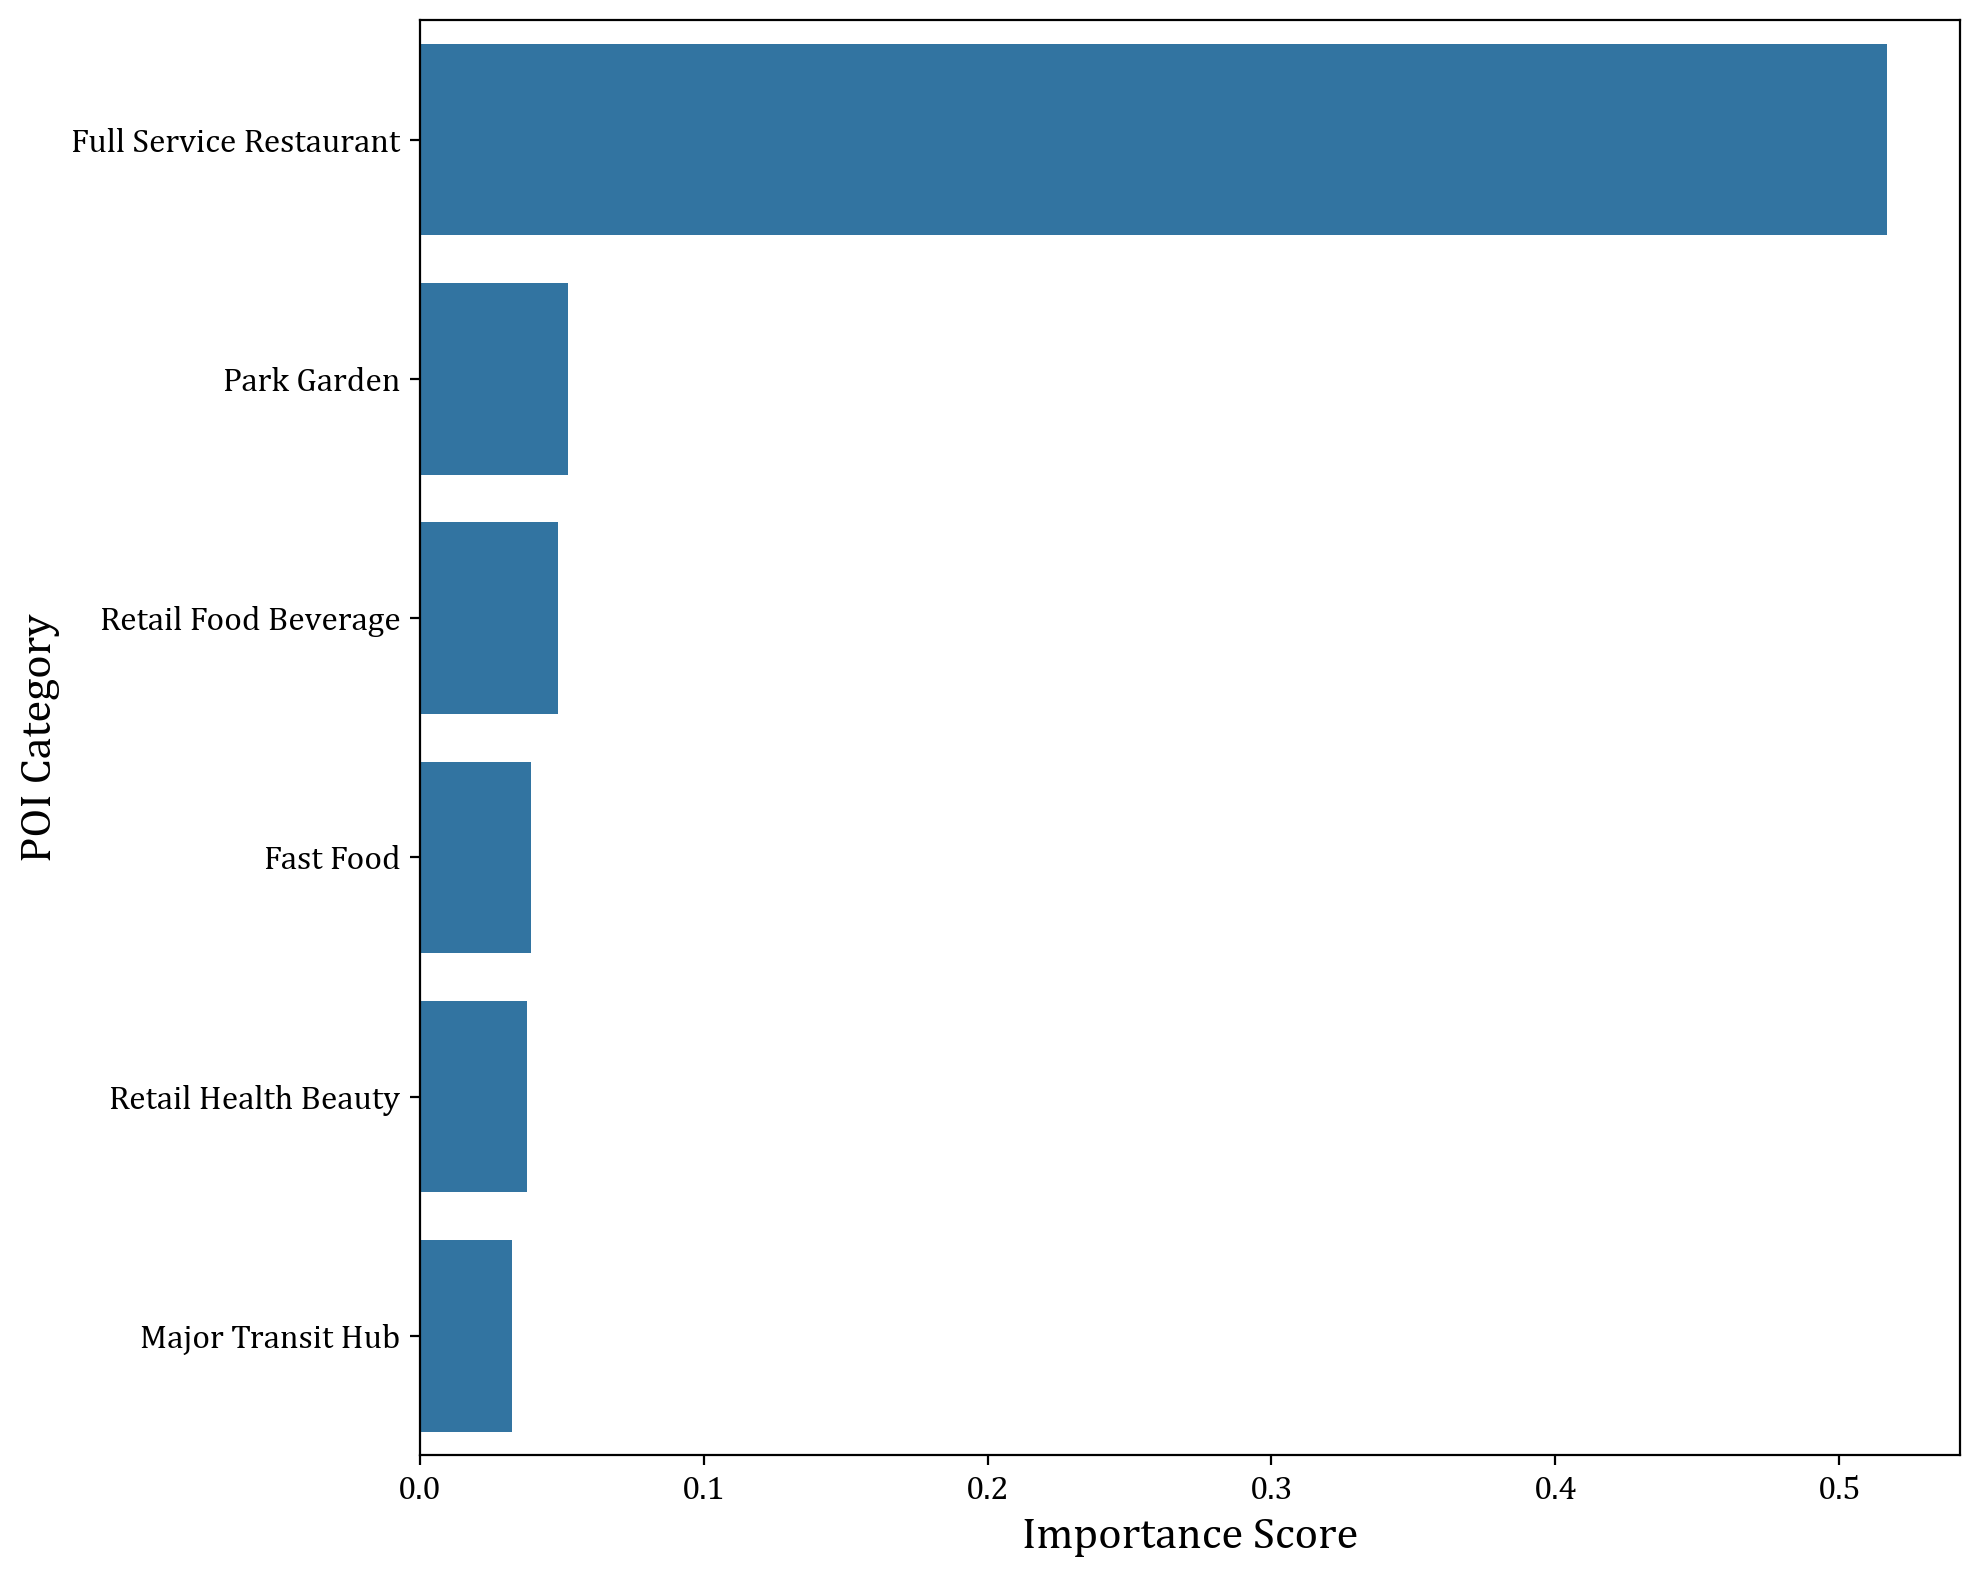


--- Top 6 Most Important Features ---
full_service_restaurant_density_log    0.516622
park_garden_density_log                0.052320
retail_food_beverage_density_log       0.048575
fast_food_density_log                  0.039063
retail_health_beauty_density_log       0.037940
major_transit_hub_density_log          0.032515
dtype: float64


In [16]:
print("=" * 50)
print("Analysing: Total Volume (number of guests)")
print("=" * 50)
# Prepare the data
X_rev, y_rev = prepare_data(edinburgh_airbnb_tourism_fs, features_logged, 'total_volume_log')
# Run the modelling pipeline
revenue_model, volume_importances = run_modelling_pipeline(X_rev, y_rev, edinburgh_airbnb_tourism_fs['total_volume'])

### Total Density

Analysing: Total Guest Density (Number of guestes per km2)
Data prepared for target: 'total_tourism_intensity_km2_log'
Number of features: 39
Number of rows after cleaning: 48

--- Training Baseline Model ---
Baseline R-squared (R²): 0.90
Baseline MAE (log): 0.650
Baseline RMSE (log): 0.733
Baseline MAE (original): 156.84
Baseline RMSE (original): 266.83

--- Starting Hyperparameter Tuning ---
Tuning complete.
Best parameters found: {'n_estimators': 300, 'min_samples_leaf': 4, 'max_features': 1.0, 'max_depth': None}
Tuned R-squared (R²): 0.82
Tuned MAE (log): 0.805
Tuned RMSE (log): 0.963
Tuned MAE (original): 229.07
Tuned RMSE (original): 399.57


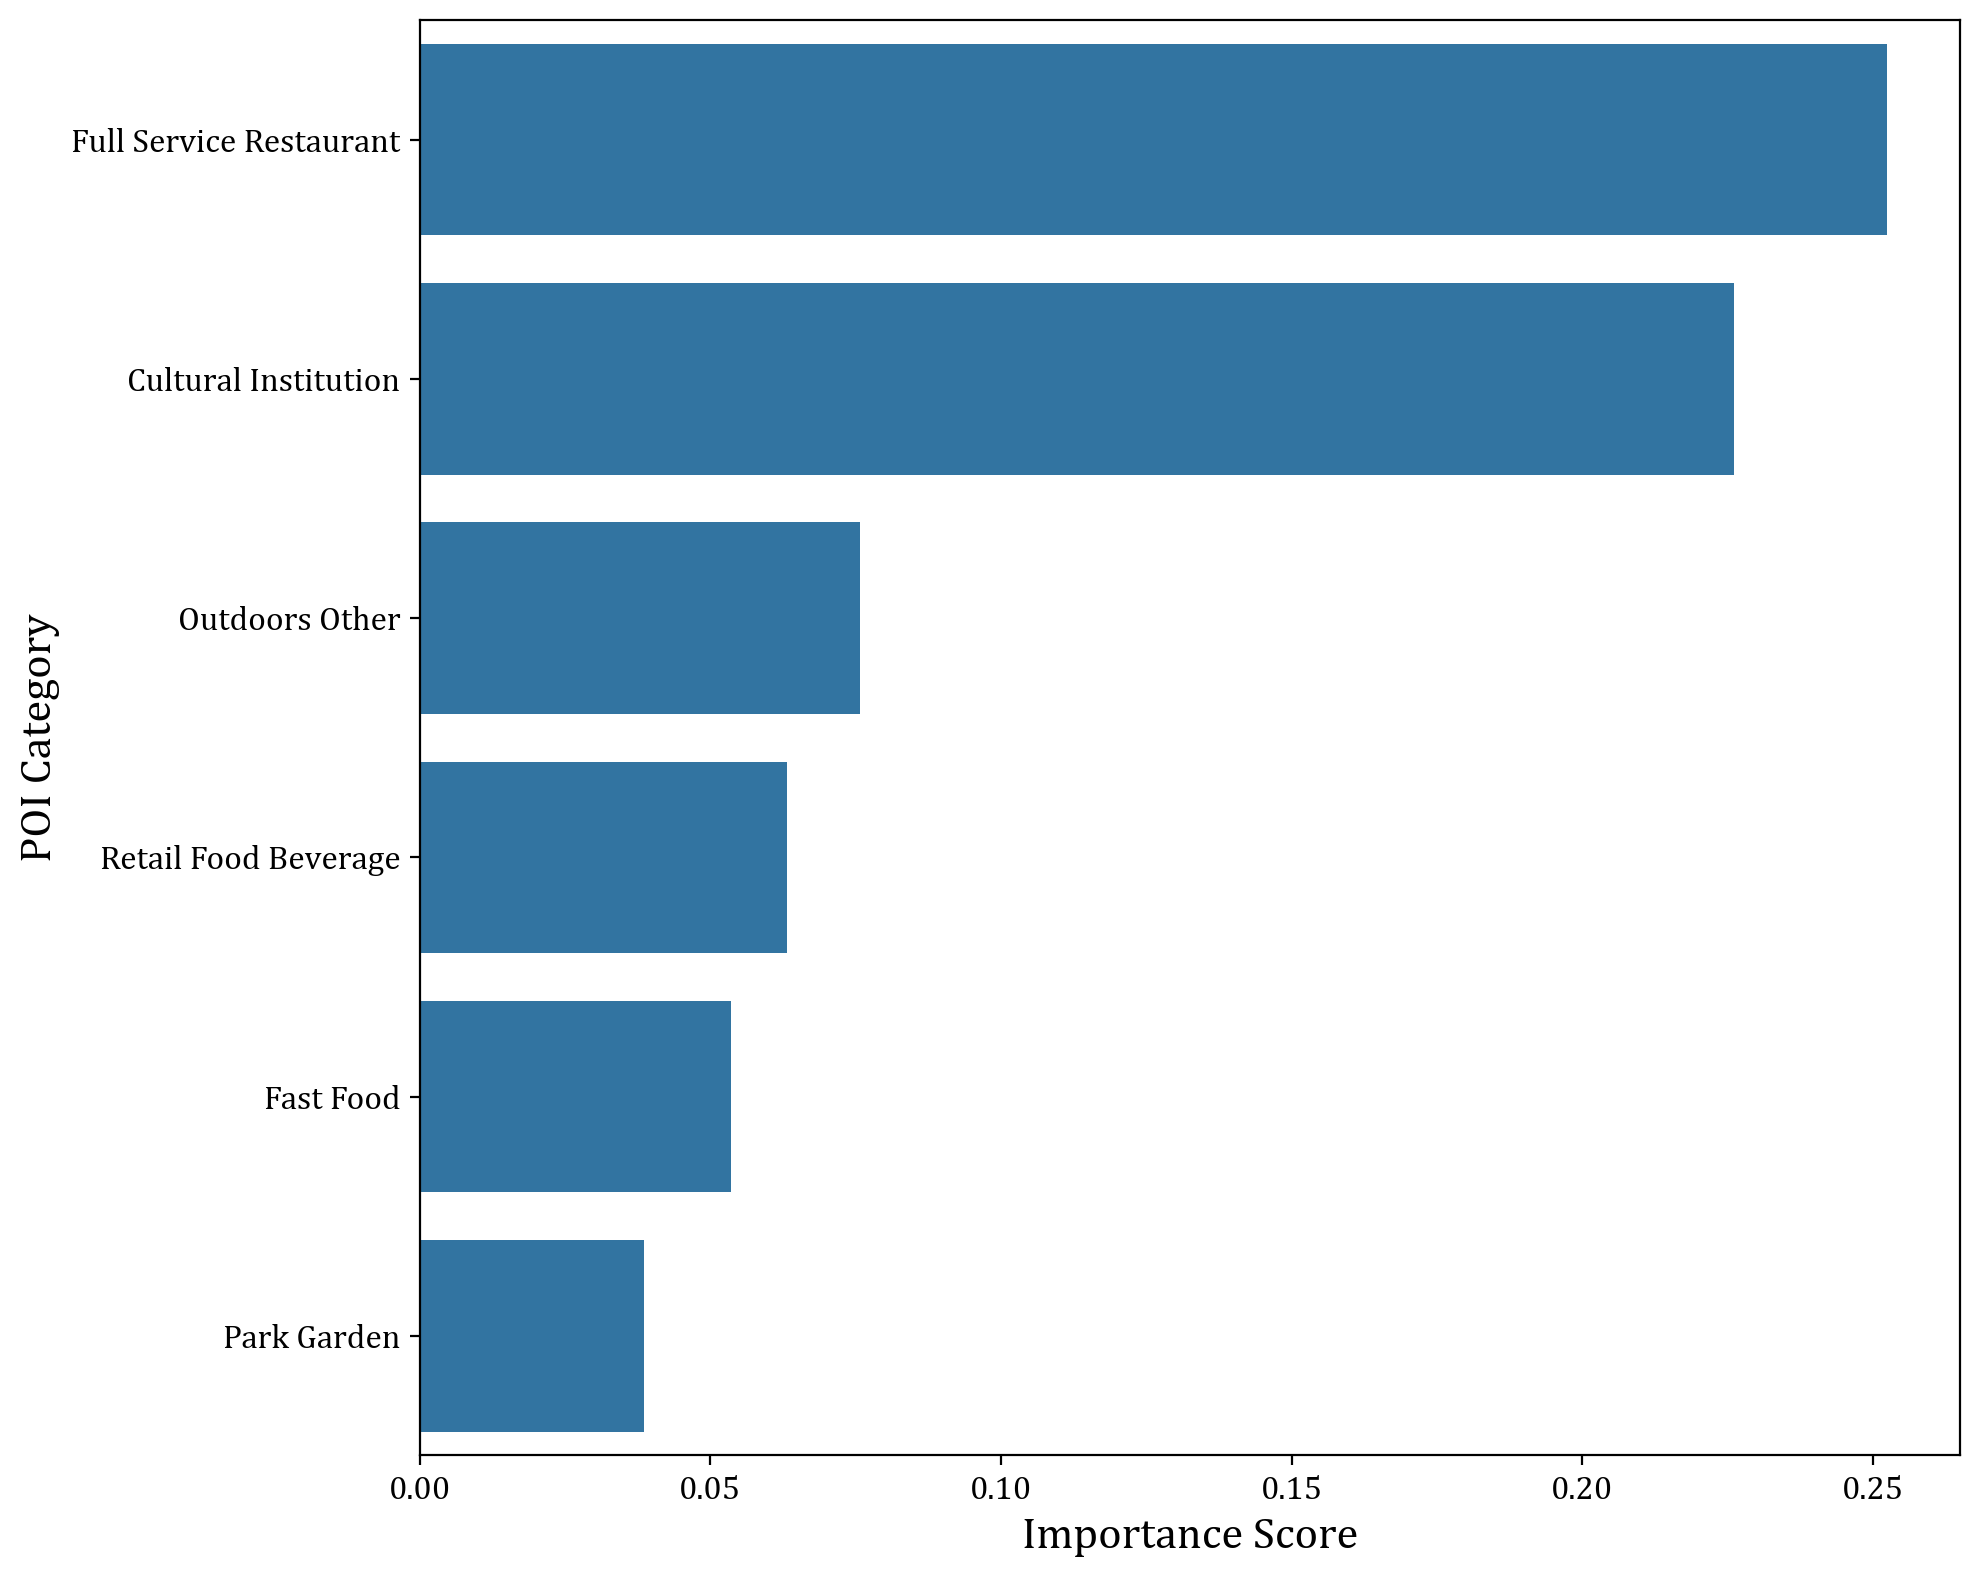


--- Top 6 Most Important Features ---
full_service_restaurant_density_log    0.252328
cultural_institution_density_log       0.226104
outdoors_other_density_log             0.075742
retail_food_beverage_density_log       0.063217
fast_food_density_log                  0.053551
park_garden_density_log                0.038540
dtype: float64


In [17]:
print("=" * 50)
print("Analysing: Total Guest Density (Number of guestes per km2)")
print("=" * 50)
# Prepare the data
X_rev, y_rev = prepare_data(edinburgh_airbnb_tourism_fs, features_logged, 'total_tourism_intensity_km2_log')
# Run the modelling pipeline
revenue_model, density_importances = run_modelling_pipeline(X_rev, y_rev, edinburgh_airbnb_tourism_fs['total_tourism_intensity_km2'])

## 4. Geographically Weighted Regression

In [ ]:
# Fix geometry

# Rename id in edinburgh_glx to glx_id
edinburgh_glx = edinburgh_glx.rename(columns={'id': 'glx_id'})

# Extract just the geometry and glx_id from edinburgh_glx
edinburgh_geometry = edinburgh_glx[['glx_id', 'geometry']]

# Merge only the geometry into the tourism dataframe (without bringing extra columns)
edinburgh_airbnb_tourism_fs = edinburgh_airbnb_tourism_fs.drop(columns='geometry', errors='ignore')  # Drop if already exists

edinburgh_airbnb_tourism_fs = edinburgh_airbnb_tourism_fs.merge(
    edinburgh_geometry,
    on='glx_id',
    how='left'
)

# Convert to GeoDataFrame
edinburgh_airbnb_tourism_fs = gpd.GeoDataFrame(edinburgh_airbnb_tourism_fs, geometry='geometry')


In [8]:
# Define your X (features), y (target), and coordinates
gwr_features = [
    'cultural_institution_density_log',
    'full_service_restaurant_density_log',
    'park_garden_density_log'
]

targets = {
    "revenue": "total_revenue_log",
    "volume": "total_volume_log",
    "density": "tourism_intensity_km2_log"
}

def run_gwr_for_target(gdf_input, target_var, gwr_features):
    # Drop missing values
    gdf = gdf_input.dropna(subset=[target_var] + gwr_features).copy()

    # Prepare data
    X = gdf[gwr_features].values
    y = gdf[[target_var]].values

    u = gdf.geometry.centroid.x.values
    v = gdf.geometry.centroid.y.values
    coords = np.column_stack([u, v])

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Bandwidth selection
    selector = Sel_BW(coords, y, X_scaled)
    opt_bw = selector.search()

    # Fit GWR model
    gwr_model = GWR(coords, y, X_scaled, bw=opt_bw)
    gwr_results = gwr_model.fit()

    # Add coefficients to GeoDataFrame
    for i, feature in enumerate(gwr_features):
        gdf[f"gwr_coeff_{feature}"] = gwr_results.params[:, i + 1]  # i+1 skips intercept

    # Calculate t-values and significance
    for i, feature in enumerate(gwr_features):
        coeffs = gwr_results.params[:, i + 1]
        std_errors = gwr_results.bse[:, i + 1]
        t_values = coeffs / std_errors
        gdf[f"t_value_{feature}"] = t_values
        gdf[f"significance_{feature}"] = np.where(
            (t_values > 2) | (t_values < -2), "Significant", "Non-significant"
        )

    # Print global R²
    print(f"Global R² for {target_var}:", round(gwr_results.R2, 3))

    return gdf

In [9]:
gdf_revenue = run_gwr_for_target(edinburgh_airbnb_tourism_fs, "total_revenue_log", gwr_features)
gdf_volume = run_gwr_for_target(edinburgh_airbnb_tourism_fs, "total_volume_log", gwr_features)
gdf_density = run_gwr_for_target(edinburgh_airbnb_tourism_fs, "total_tourism_intensity_km2_log", gwr_features)

Global R² for total_revenue_log: 0.688
Global R² for total_volume_log: 0.683
Global R² for total_tourism_intensity_km2_log: 0.876


/var/folders/1n/_7fnqrv504n3tlnbg2hqgkdh0000gn/T/ipykernel_15666/2434496582.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


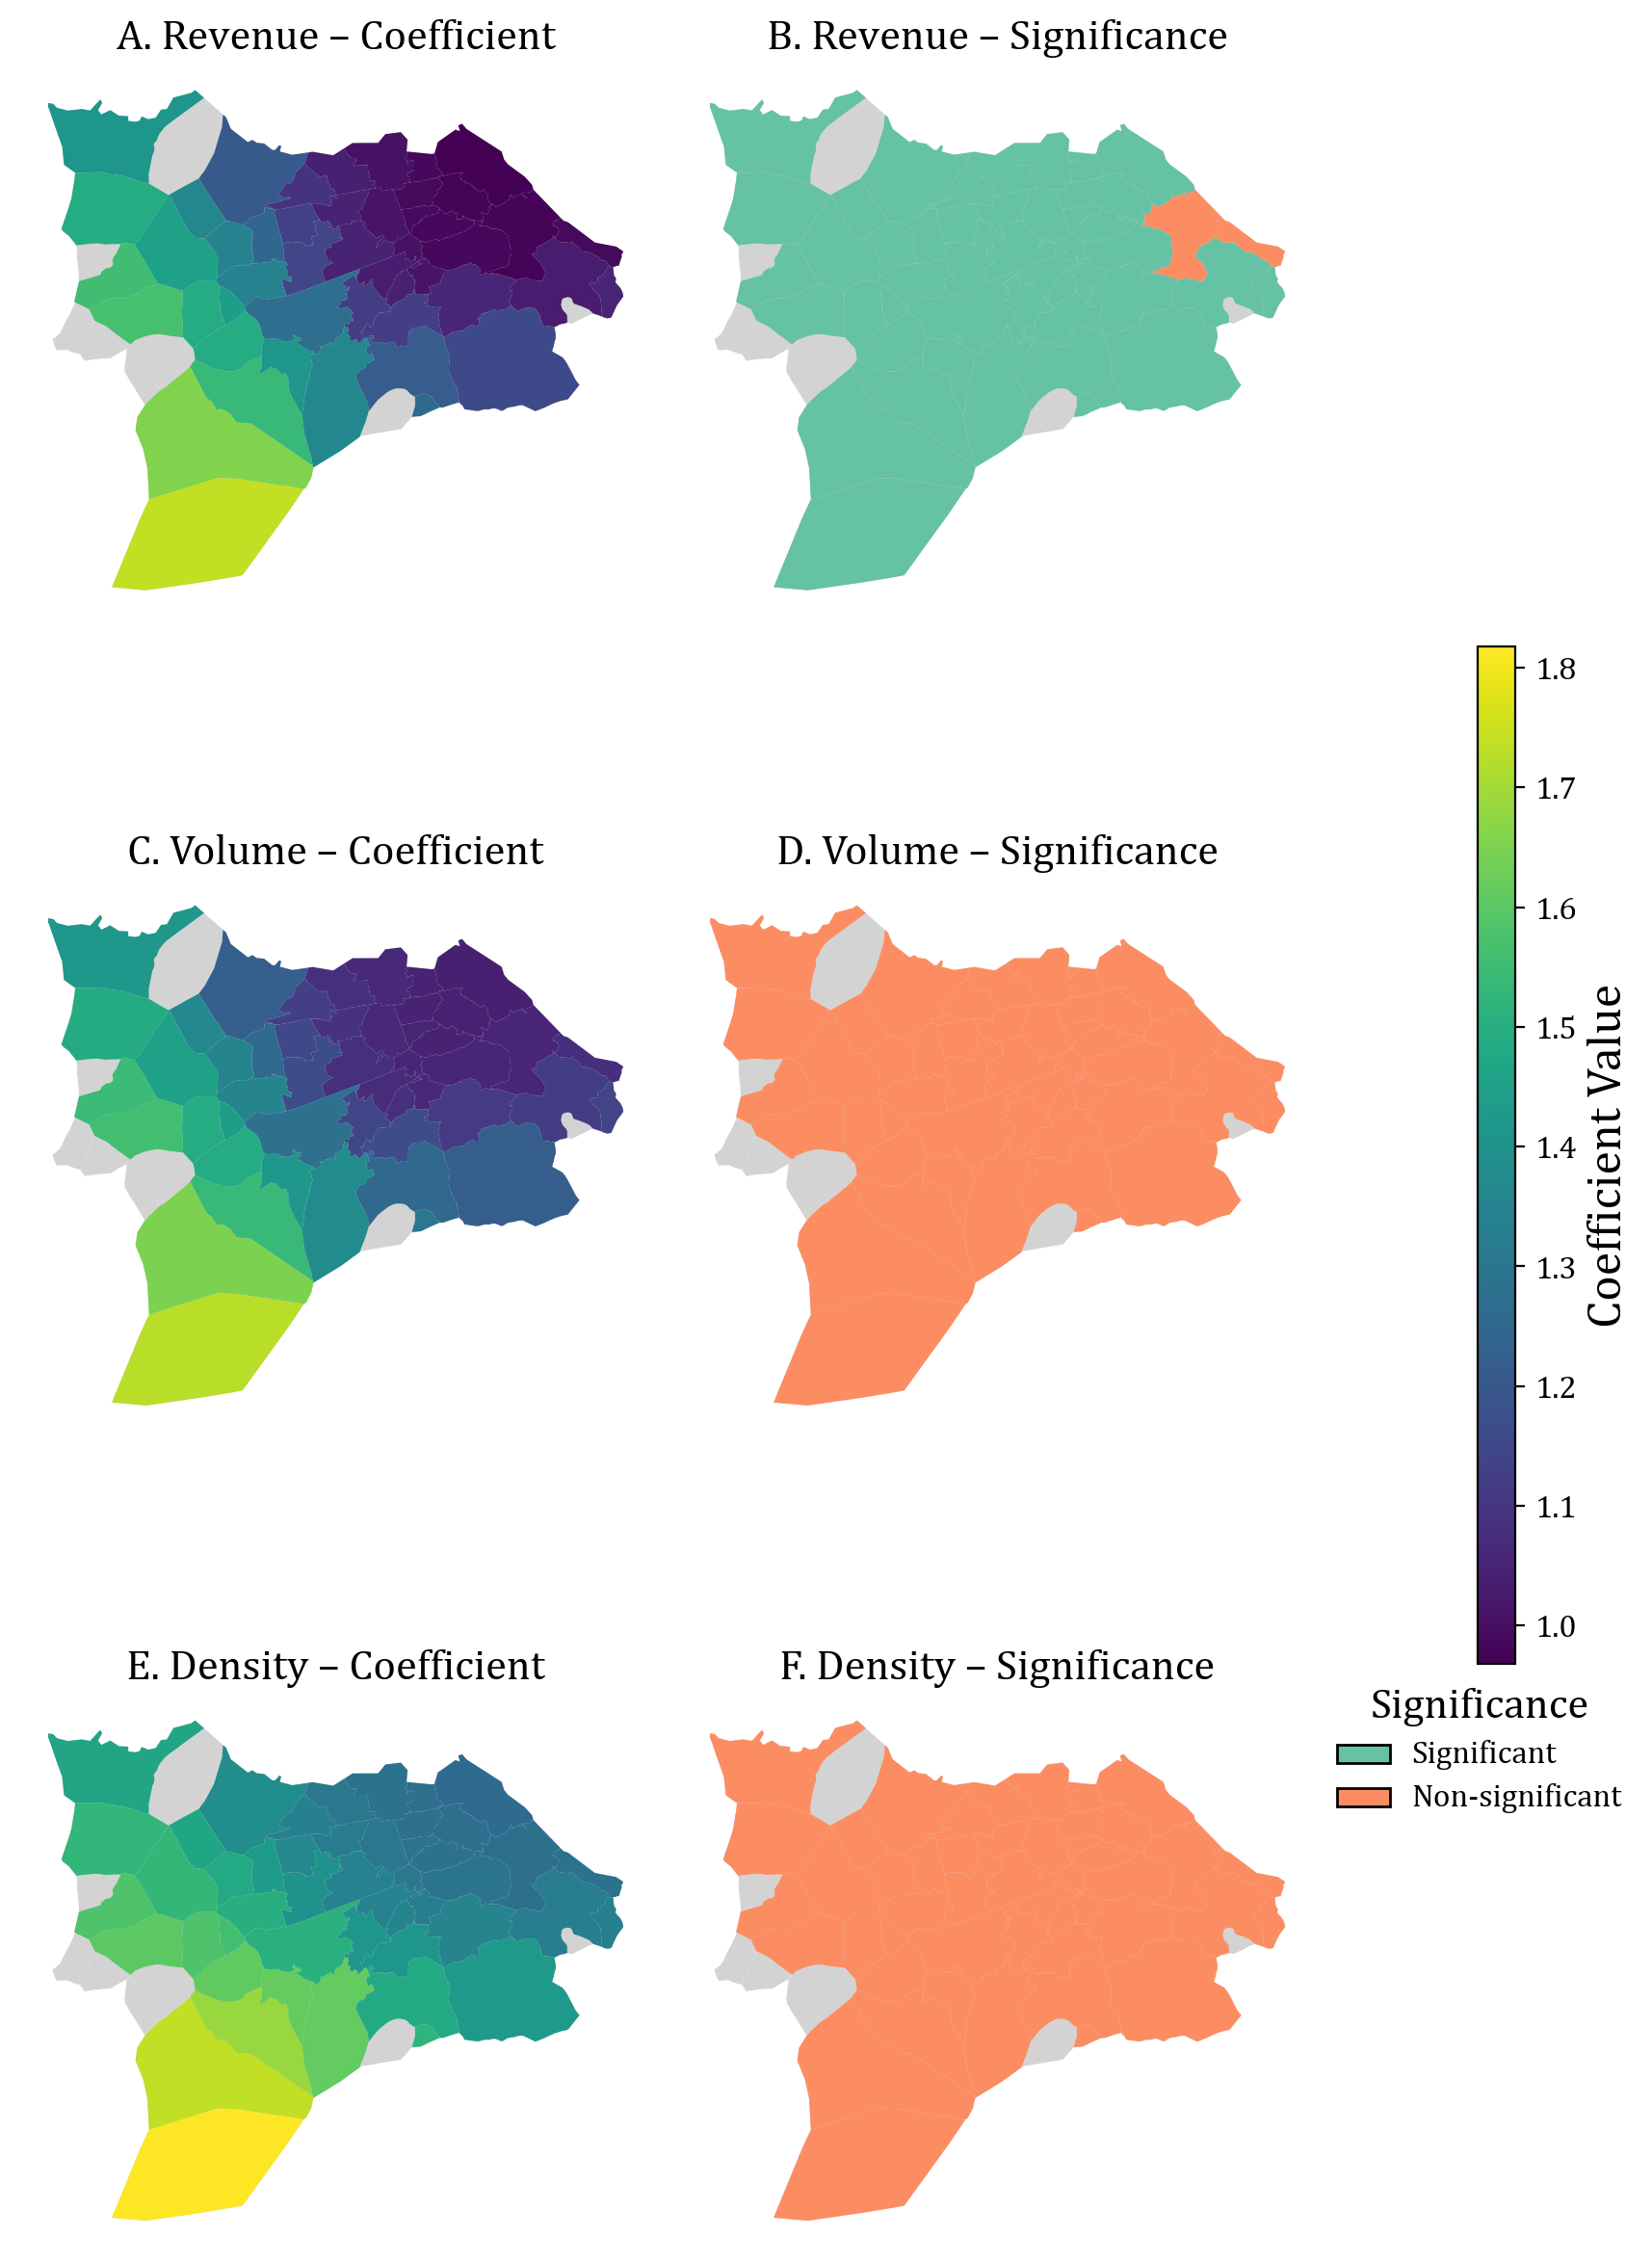

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(7.8, 13.2))

# Define inputs for each row
gwr_dfs = [gdf_revenue, gdf_volume, gdf_density]
titles = ['Revenue', 'Volume', 'Density']
feature = 'full_service_restaurant_density_log'
pretty_name = 'Full-Service Restaurant'

# Shared coefficient color scale
coeff_vmin = min([df[f'gwr_coeff_{feature}'].min() for df in gwr_dfs])
coeff_vmax = max([df[f'gwr_coeff_{feature}'].max() for df in gwr_dfs])

significance_cmap = ListedColormap(['#FC8D62', '#66C2A5'])
significance_legend = [
    Patch(facecolor='#66C2A5', edgecolor='black', label='Significant'),
    Patch(facecolor='#FC8D62', edgecolor='black', label='Non-significant')
]

panel_labels = ['A', 'B', 'C', 'D', 'E', 'F']

for i, (df, title) in enumerate(zip(gwr_dfs, titles)):
    # Coefficient map
    ax_coeff = axes[i, 0]
    edinburgh_glx.plot(ax=ax_coeff, color='lightgrey')
    df.plot(
        column=f'gwr_coeff_{feature}', ax=ax_coeff,
        cmap='viridis', vmin=coeff_vmin, vmax=coeff_vmax, legend=False
    )
    ax_coeff.set_title(f'{panel_labels[i*2]}. {title} – Coefficient', fontproperties=cambria_prop, fontsize=16)
    ax_coeff.axis('off')

    # Significance map
    ax_sig = axes[i, 1]
    edinburgh_glx.plot(ax=ax_sig, color='lightgrey')
    df.plot(
        column=f'significance_{feature}', ax=ax_sig,
        cmap=significance_cmap, legend=False
    )
    ax_sig.set_title(f'{panel_labels[i*2+1]}. {title} – Significance', fontproperties=cambria_prop, fontsize=16)
    ax_sig.axis('off')

# Shared colorbar for coefficients
cax = fig.add_axes([0.99, 0.3, 0.025, 0.4])
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=coeff_vmin, vmax=coeff_vmax))
sm._A = []
cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_label('Coefficient Value', fontsize=18, fontproperties=cambria_prop)
# Set tick label font size and font
for label in cbar.ax.get_yticklabels(): 
    label.set_fontproperties(cambria_prop)
    label.set_fontsize(12)

# Significance legend
legend_ax = fig.add_axes([0.88, 0.2, 0.08, 0.1])
legend_ax.axis('off')
legend = legend_ax.legend(
    handles=significance_legend,
    title='Significance',
    loc='upper left',
    frameon=False
)

legend.get_title().set_fontproperties(cambria_prop)
legend.get_title().set_fontsize(16)
for text in legend.get_texts():
    text.set_fontproperties(cambria_prop)
    text.set_fontsize(12)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.savefig('../../results/edinburgh/gwr_results.png', dpi=500, bbox_inches='tight')
plt.show()

## 5. Geographically Weighted Random Forest

In [14]:
# Define the mapping for POI categories to their levels
poi_group_map = {
    'outdoors_other_density' : 'Landmarks and Outdoors',
    'retail_other_density' : 'Retail',
    'retail_gifts_misc_density' : 'Retail',
    'retail_home_electronics_density' : 'Retail',
    'local_public_transit_density' : 'Travel and Transportation',
    'park_garden_density' : 'Landmarks and Outdoors',
    'retail_health_beauty_density' : 'Retail',
    'retail_food_beverage_density' : 'Retail',
    'fast_food_density' : 'Dining and Drinking',
    'cafes_bakeries_density' : 'Dining and Drinking',
    'dining_other_density' : 'Dining and Drinking',
    'transport_infrastructure_density' : 'Travel and Transportation',
    'arts_other_density' : 'Arts and Entertainment',
    'full_service_restaurant_density' : 'Dining and Drinking',
    'mobility_services_density' : 'Travel and Transportation',
    'travel_other_density' : 'Travel and Transportation',
    'retail_fashion_apparel_density' : 'Retail',
    'tourism_services_density' : 'Travel and Transportation',
    'retail_luxury_density' : 'Retail',
    'cultural_institution_density' : 'Arts and Entertainment',
    'retail_books_hobbies_density' : 'Retail',
    'bars_nightlife_density' : 'Arts and Entertainment',
    'major_transit_hub_density' : 'Travel and Transportation',
    'high_end_dining_density' : 'Dining and Drinking',
    'nature_trail_density' : 'Landmarks and Outdoors',
    'lodging_density' : 'Travel and Transportation',
    'entertainment_nightlife_density' : 'Arts and Entertainment',
    'waterfront_river_density' : 'Landmarks and Outdoors',
    'historic_landmark_density' : 'Landmarks and Outdoors',
    'air_travel_density' : 'Travel and Transportation',
    'leisure_activity_centre_density' : 'Arts and Entertainment',
    'music_cinema_venue_density' : 'Arts and Entertainment',
    'public_art_density' : 'Arts and Entertainment',
    'retail_markets_plazas_density' : 'Retail',
    'rural_agricultural_density' : 'Landmarks and Outdoors',
    'major_attraction_density' : 'Arts and Entertainment',
    'public_plaza_square_density' : 'Landmarks and Outdoors',
    'food_drink_production_density' : 'Dining and Drinking',
    'event_space_density' : 'Arts and Entertainment'
}

### Revenue

In [15]:
# Prepare data
revenue_grf = edinburgh_airbnb_tourism_fs.copy()

# Filter out missing values
revenue_grf = revenue_grf.dropna(subset=['total_revenue_log'] + features_logged)

# Extract features (X), target (y), and coordinates
X = revenue_grf[features_logged]
y = revenue_grf['total_revenue_log']

# Coordinates from geometry centroids
coords = np.array([[geom.centroid.x, geom.centroid.y] for geom in revenue_grf.geometry])

# Train/test split (also split the coords)
X_train, X_test, y_train, y_test, coords_train, coords_test = train_test_split(
    X, y, coords, test_size=0.2, random_state=42
)

In [ ]:
# Use training data and coordinates
rev_best_bw = search_bandwidth(
    X_train,
    y_train,
    coords_train,
    bw_min=10,
    bw_max=30,
    step=5,
    n_estimators=750,
    max_features='sqrt',
    train_weighted=True,
    random_state=42
)

print("Best bandwidth:", rev_best_bw)

bandwidth: 10 mixed: 0.5216
bandwidth: 15 mixed: 0.5419
bandwidth: 20 mixed: 0.784
bandwidth: 25 mixed: 0.5239
bandwidth: 30 mixed: 0.5149
Best Bandwidth:  20.0
Best bandwidth: {'bandwidth_search_result':    bandwidth     mixed
0         10  0.521578
1         15  0.541924
2         20  0.783957
3         25  0.523941
4         30  0.514890, 'best_bandwidth': np.float64(20.0)}


In [16]:
from PyGRF import search_bandwidth
from PyGRF import PyGRFBuilder

# Create PyGRF model
model = PyGRF.PyGRFBuilder(
    n_estimators=750,
    max_features='sqrt',
    band_width=36,
    train_weighted=True,
    predict_weighted=True,
    bootstrap=True,
    resampled=True,
    random_state=42,
    kernel="adaptive"
)

# Fit the model on training data
print("Fitting model...")
model.fit(X_train, y_train, coords_train)

# Get the local R2 values
rev_local_R2 = PyGRFBuilder.get_local_R2(model)

# Predict on test set
predict_combined, predict_global, predict_local = model.predict(
    X_test, coords_test, local_weight=0.46
)

# Evaluate on log scale
r2_combined = r2_score(y_test, predict_combined)
rmse_combined = np.sqrt(mean_squared_error(y_test, predict_combined))
mae_combined = mean_absolute_error(y_test, predict_combined)

# Evaluate on original scale
y_test_exp = np.exp(y_test)
predict_combined_exp = np.exp(predict_combined)

# Evaluate performance
r2_combined = r2_score(y_test, predict_combined)

rmse_combined_exp = np.sqrt(mean_squared_error(y_test_exp, predict_combined_exp))
mae_combined_exp = mean_absolute_error(y_test_exp, predict_combined_exp)

# Print all
print("Combined model R² (log scale):", round(r2_combined, 3))
print("Combined model RMSE (log scale):", round(rmse_combined, 3))
print("Combined model MAE (log scale):", round(mae_combined, 3))

print("Combined model RMSE (original scale):", round(rmse_combined_exp, 2))
print("Combined model MAE (original scale):", round(mae_combined_exp, 2))

Fitting model...


/opt/anaconda3/envs/geolytix/lib/python3.12/site-packages/PyGRF/PyGRF.py:344: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  R2_df = pd.concat([R2_df, pd.DataFrame([this_row], columns=column_list)], ignore_index=True)


Combined model R² (log scale): 0.717
Combined model RMSE (log scale): 1.283
Combined model MAE (log scale): 1.177
Combined model RMSE (original scale): 8975045.9
Combined model MAE (original scale): 5163017.32


bw 20: 0.71
bw 35: 0.72
bw 25: 0.71
bw 36: 0.72

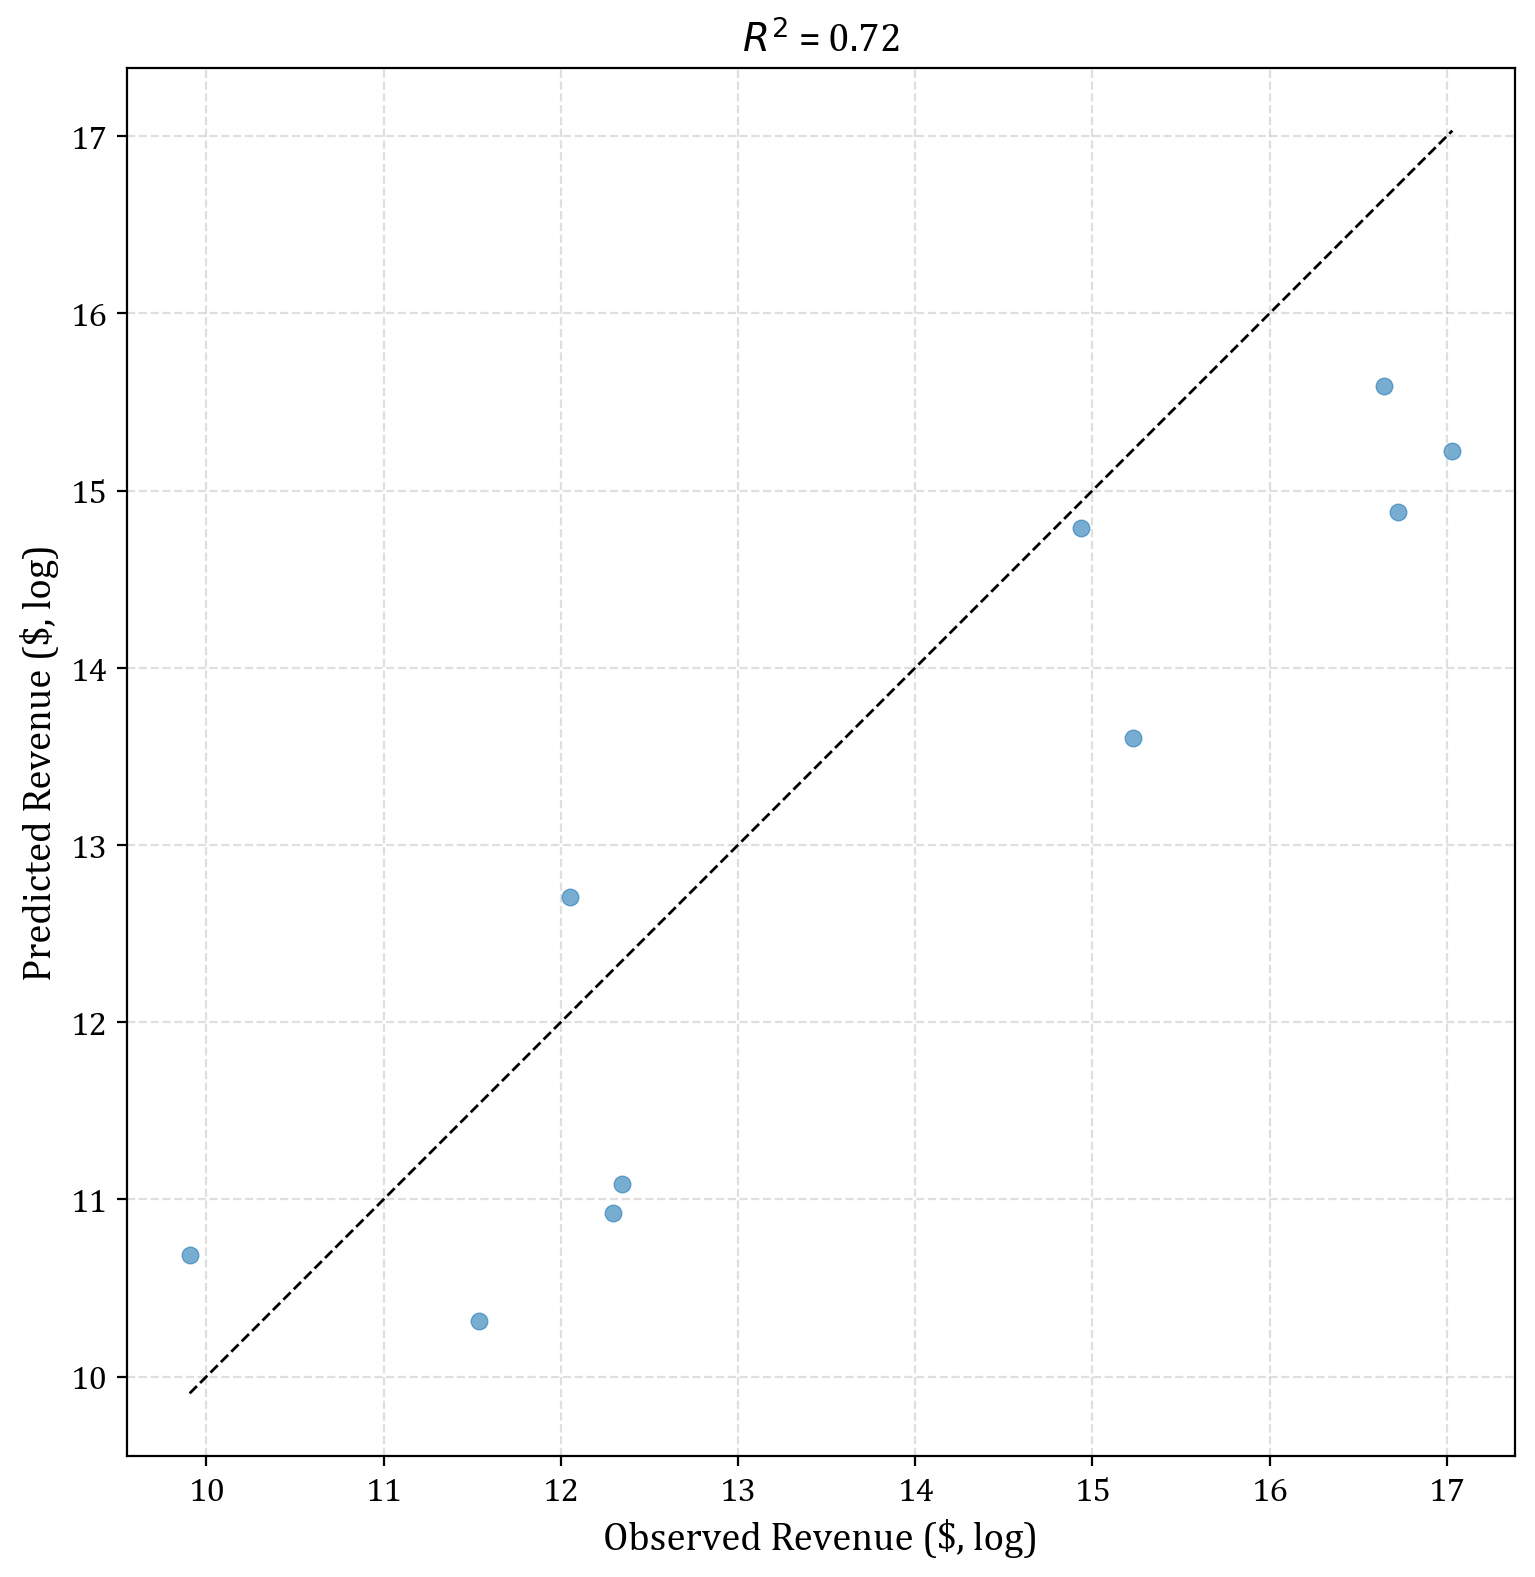

In [17]:
actual_test = np.array(y_test)
predicted_test = np.array(predict_combined)

# R²
r2 = r2_score(actual_test, predicted_test)

plt.figure(figsize=(8, 8))
sns.scatterplot(x=actual_test, y=predicted_test, alpha=0.6, edgecolor=None)

# 1:1 line
lims = [min(actual_test.min(), predicted_test.min()), max(actual_test.max(), predicted_test.max())]
plt.plot(lims, lims, 'k--', linewidth=1)

# Labels and title
plt.xlabel("Observed Revenue ($, log)", fontproperties=cambria_prop, fontsize=14)
plt.ylabel("Predicted Revenue ($, log)", fontproperties=cambria_prop, fontsize=14)
plt.title(f"$R^2$ = {r2:.2f}", fontproperties=cambria_prop, fontsize=14)

# Set tick labels to Cambria
ax = plt.gca()
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(cambria_prop)
    label.set_fontsize(12)

ax.set_aspect('equal', adjustable='box')
ax.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.savefig('../../results/edinburgh/grf_revenue_predicted_vs_observed_test.png', dpi=500, bbox_inches='tight')
plt.show()

In [18]:
# Prepare full dataframe
gdf_full = edinburgh_airbnb_tourism_fs.copy()
gdf_full = gdf_full.dropna(subset=['total_revenue_log'] + features_logged)

# Extract X, y, and coords
X_full = gdf_full[features_logged]
y_full = gdf_full['total_revenue_log']
coords_full = np.array([[geom.centroid.x, geom.centroid.y] for geom in gdf_full.geometry])

# Fit GRF model on ALL data
model_full = PyGRFBuilder(
    n_estimators=750,
    max_features='sqrt',
    band_width=36,
    train_weighted=True,
    predict_weighted=True,
    bootstrap=False,
    resampled=True,
    random_state=42,
    kernel="adaptive"
)

model_full.fit(X_full, y_full, coords_full)

# Get local feature importances
local_importance = model_full.get_local_feature_importance().reset_index(drop=True)

# Attach to gdf and get top predictor
gdf_full = gdf_full.reset_index(drop=True)
gdf_full = pd.concat([gdf_full, local_importance], axis=1)

# Only consider true feature columns (remove any metadata if present)
feature_cols_only = [col for col in local_importance.columns if col in features_logged]

# Compute top predictor
gdf_full['top_predictor'] = local_importance[feature_cols_only].idxmax(axis=1)

/opt/anaconda3/envs/geolytix/lib/python3.12/site-packages/PyGRF/PyGRF.py:319: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  feature_importance_df = pd.concat([feature_importance_df, pd.DataFrame([this_row], columns=column_list)], ignore_index=True)


In [ ]:
# Copy gdf_full into gdf_revenue
gdf_revenue = gdf_full.copy()

# Strip '_log' suffix from top_predictor to match keys
gdf_revenue['top_predictor_stripped'] = gdf_revenue['top_predictor'].str.replace('_log', '', regex=False)

# Map each stripped predictor to its high-level POI group
gdf_revenue['top_predictor_group'] = gdf_revenue['top_predictor_stripped'].map(poi_group_map)

In [ ]:
custom_poi_color_map = {
    "Arts and Entertainment": "#1f77b4",
    "Dining and Drinking": "#aec7e8",
    "Landmarks and Outdoors": "#ff7f0e",
    "Retail": "#ffbb78",
    "Travel and Transportation": "#2ca02c"
}

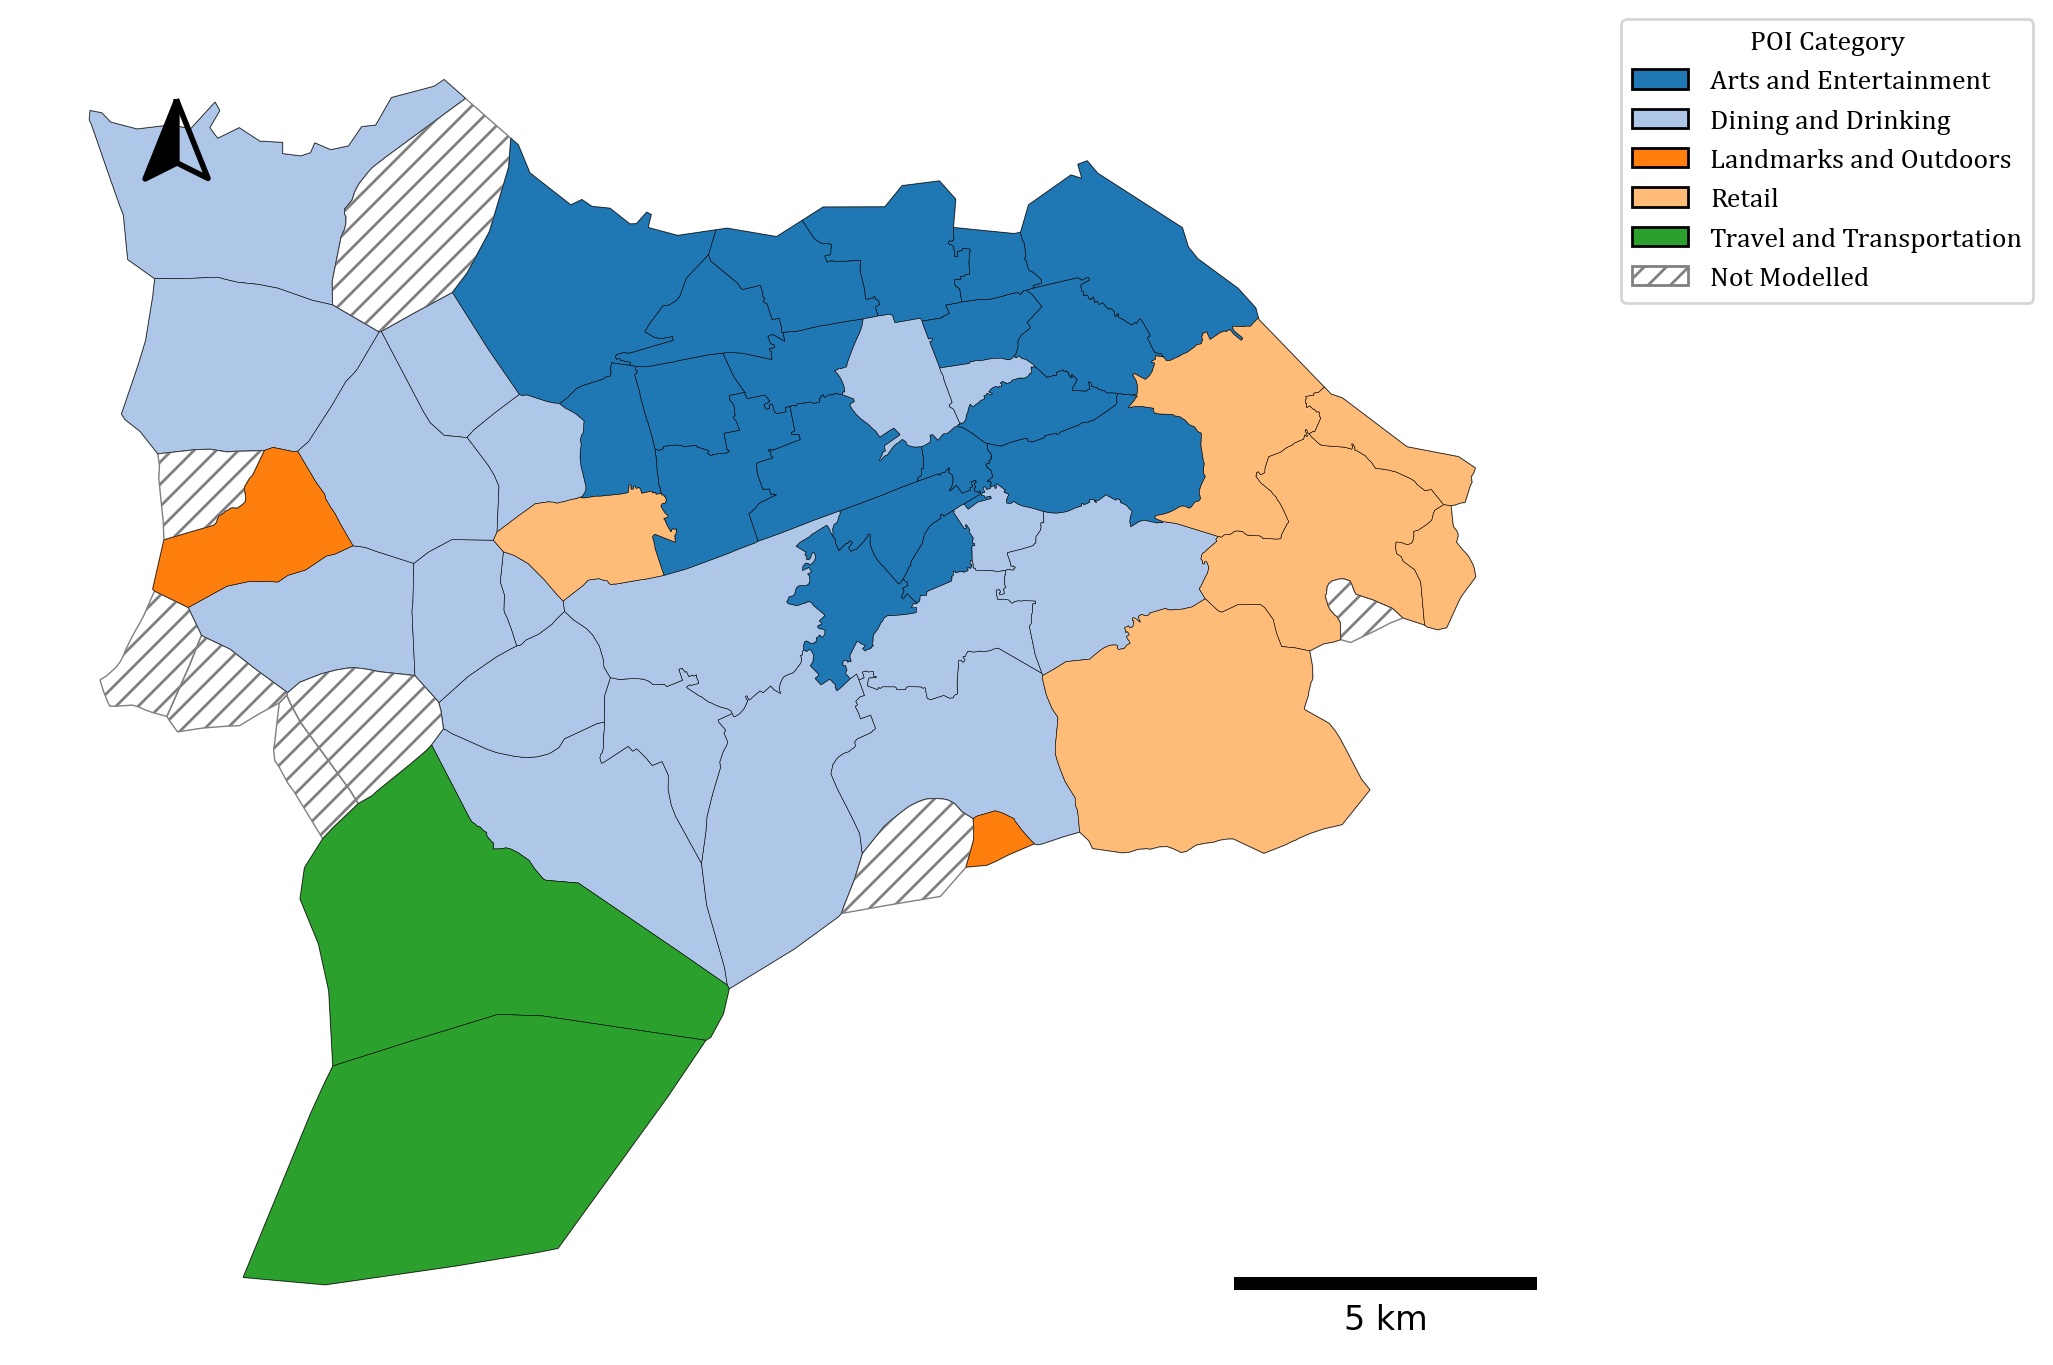

In [ ]:
# Strip '_log' and map to top-level category
gdf_revenue['top_predictor_stripped'] = gdf_revenue['top_predictor'].str.replace('_log', '', regex=False)
gdf_revenue['top_poi_level1'] = gdf_revenue['top_predictor_stripped'].map(poi_group_map)

poi_color_map = custom_poi_color_map

present_pois = gdf_revenue['top_poi_level1'].unique()

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Plot full base shapefile with hatch for areas not in model
edinburgh_glx.plot(
    ax=ax,
    facecolor="none",
    edgecolor="grey",
    hatch="///",
    linewidth=0.5,
    zorder=0
)

# Plot valid GRF neighbourhoods by POI category
for poi, color in poi_color_map.items():
    subset = gdf_revenue[gdf_revenue["top_poi_level1"] == poi]
    subset.plot(ax=ax, color=color, edgecolor="black", linewidth=0.2, zorder=1)

# Legend
legend_elements = [
    Patch(facecolor=poi_color_map[poi], edgecolor='black', label=poi)
    for poi in unique_pois
]
# Add legend entry for hatch
legend_elements.append(
    Patch(facecolor='white', edgecolor='gray', hatch='///', label='Not Modelled')
)

legend = ax.legend(
    handles=legend_elements,
    title="POI Category",
    title_fontproperties=cambria_prop,
    prop=cambria_prop,
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    borderaxespad=0.
)

# North arrow & scale bar
#add_north_arrow(ax, scale=0.5, xlim_pos=.1025, ylim_pos=.880, color='#000', text_scaler=0, text_yT=-1.25)

#scalebar = ScaleBar(1, location="lower right", units="m", color="black", font_properties={"size": 12})
#ax.add_artist(scalebar)

# Finalise
ax.axis("off")
plt.tight_layout()
plt.savefig('../../results/edinburgh/grfRevenue_broad_poi_map.png', dpi=300, bbox_inches='tight')
plt.show()

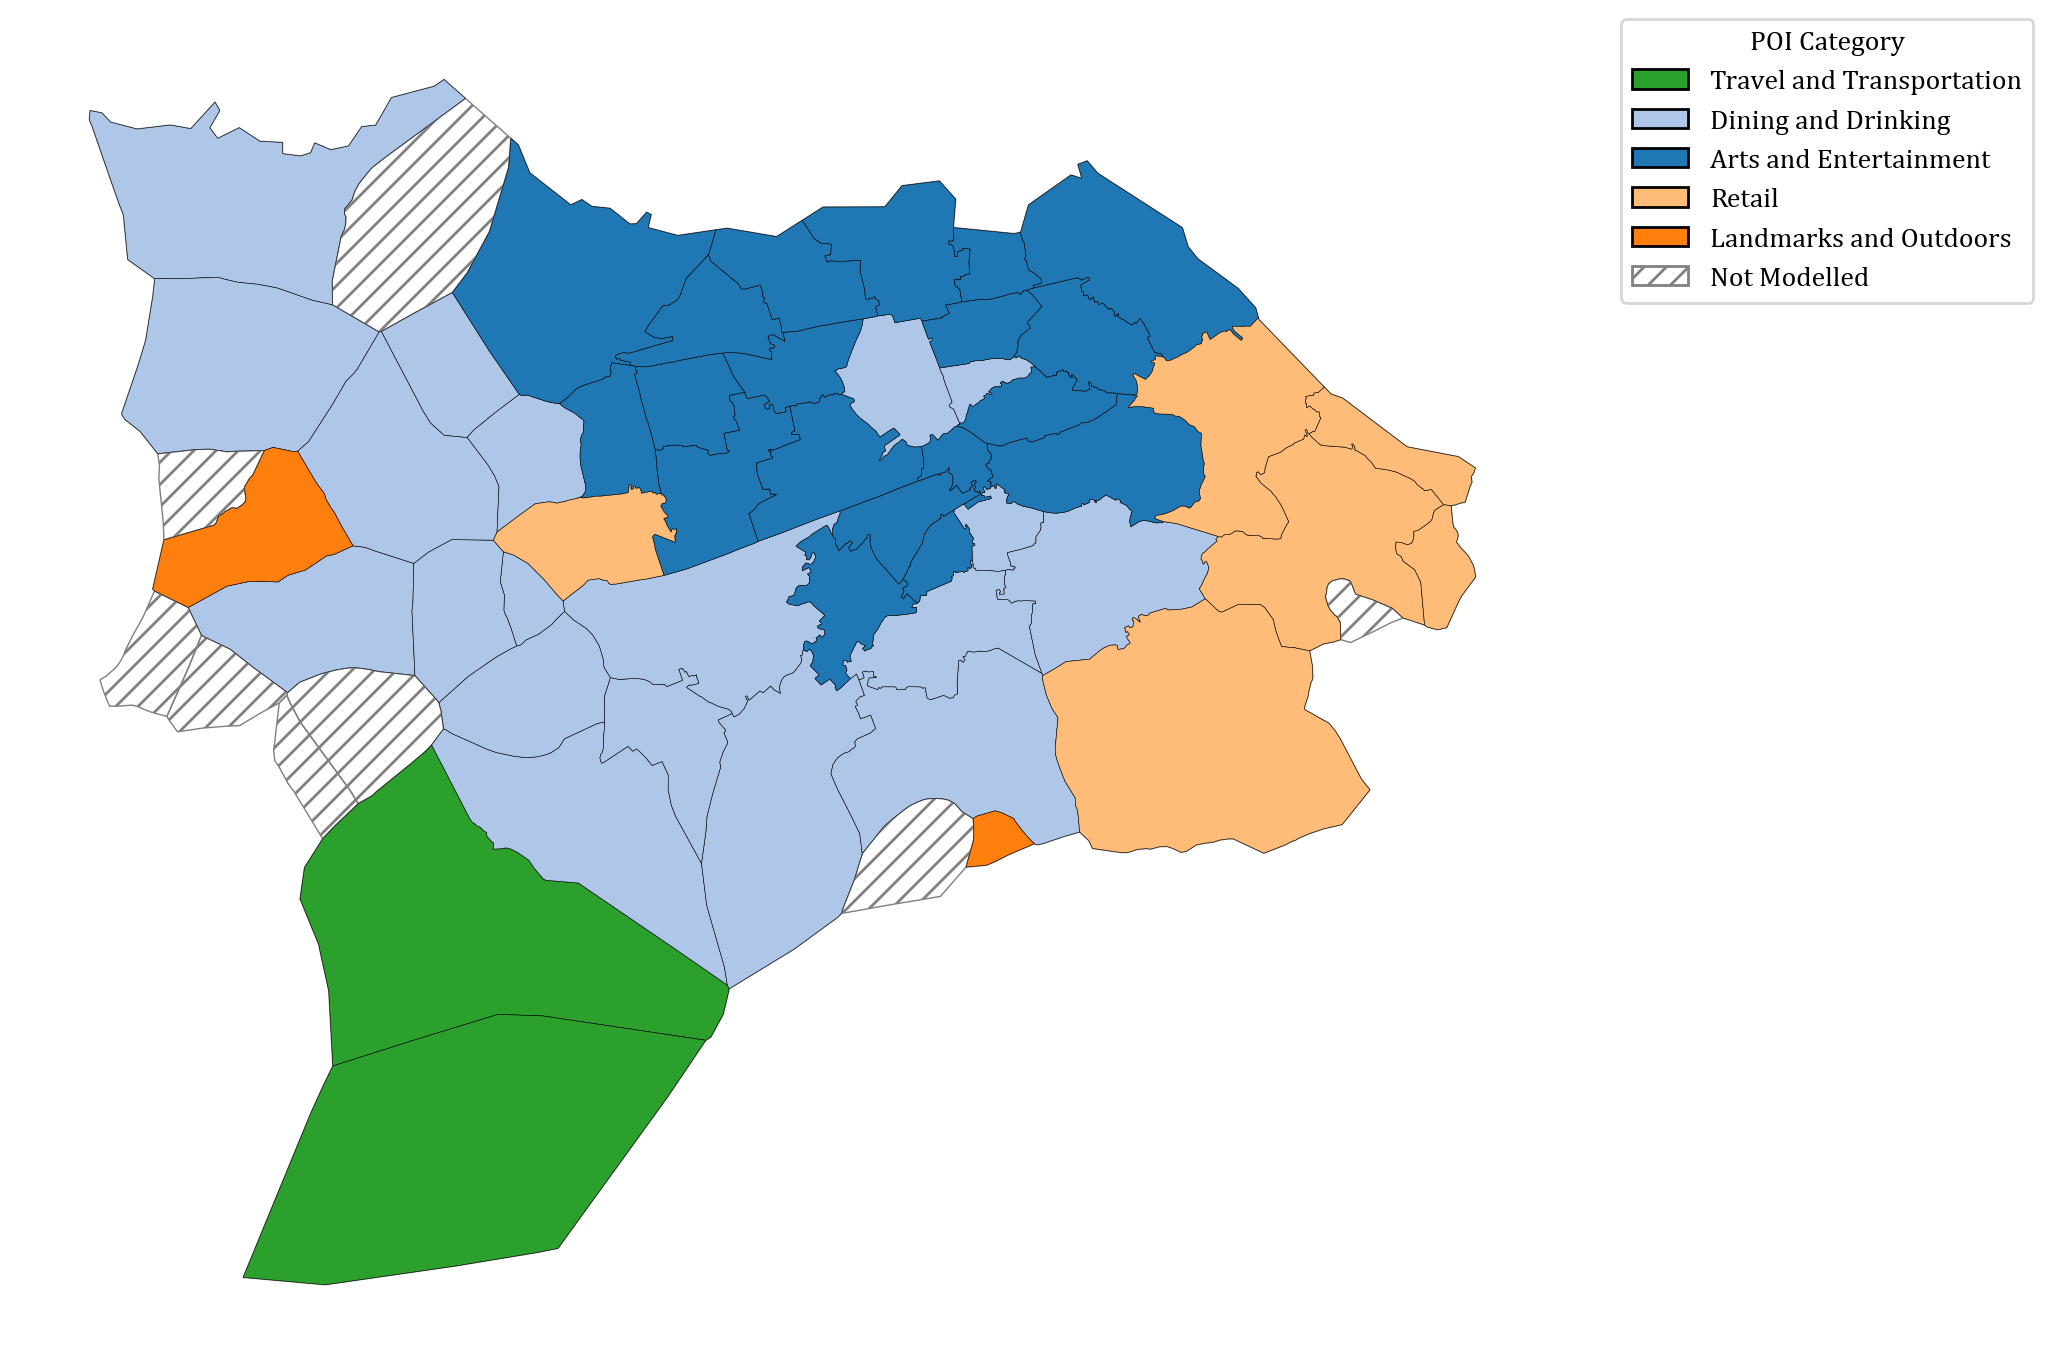

In [36]:
# Apply POI mapping 
gdf_revenue['top_predictor_stripped'] = gdf_revenue['top_predictor'].str.replace('_log', '', regex=False)
gdf_revenue['top_poi_level1'] = gdf_revenue['top_predictor_stripped'].map(poi_group_map)

# Create figure 
fig, ax = plt.subplots(figsize=(10, 8))

# Plot base layer with hatch for areas not modelled
edinburgh_glx.plot(
    ax=ax,
    facecolor="none",
    edgecolor="grey",
    hatch="///",
    linewidth=0.5,
    zorder=0
)

# Plot modelled neighbourhoods by top POI category
present_pois = gdf_revenue["top_poi_level1"].dropna().unique()

for poi in present_pois:
    if poi in custom_poi_color_map:
        subset = gdf_revenue[gdf_revenue["top_poi_level1"] == poi]
        subset.plot(
            ax=ax,
            color=custom_poi_color_map[poi],
            edgecolor="black",
            linewidth=0.2,
            zorder=1
        )

# Legend
legend_elements = [
    Patch(facecolor=custom_poi_color_map[poi], edgecolor='black', label=poi)
    for poi in present_pois if poi in custom_poi_color_map
]

# Add hatch legend for non-modelled areas
legend_elements.append(
    Patch(facecolor='white', edgecolor='gray', hatch='///', label='Not Modelled')
)

legend = ax.legend(
    handles=legend_elements,
    title="POI Category",
    title_fontproperties=cambria_prop,
    prop=cambria_prop,
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    borderaxespad=0.
)

# Finalise plot
ax.axis("off")
plt.tight_layout()
plt.savefig('../../results/edinburgh/grfRevenue_broad_poi_map.png', dpi=500, bbox_inches='tight')
plt.show()

In [20]:
# Save gdf_revenue to file
gdf_revenue = gpd.GeoDataFrame(gdf_revenue, geometry='geometry')

# Now export only the selected columns
gdf_revenue[['glx_id', 'top_predictor', 'top_poi_level1', 'geometry']].to_file(
    '../../data/edinburgh/grfRevenue.gpkg',
    driver='GPKG'
)

### Volume

In [21]:
# Prepare data
volume_grf = edinburgh_airbnb_tourism_fs.copy()

# Filter out missing values
volume_grf = volume_grf.dropna(subset=['total_volume_log'] + features_logged)

# Extract features (X), target (y), and coordinates
X = volume_grf[features_logged]
y = volume_grf['total_volume_log']

# Coordinates from geometry centroids
coords = np.array([[geom.centroid.x, geom.centroid.y] for geom in volume_grf.geometry])

# Train/test split (also split the coords)
X_train, X_test, y_train, y_test, coords_train, coords_test = train_test_split(
    X, y, coords, test_size=0.2, random_state=42
)

In [ ]:
# Use your training data and coordinates
rev_best_bw = search_bandwidth(
    X_train,
    y_train,
    coords_train,
    bw_min=2,
    bw_max=5,
    step=2,
    n_estimators=500,
    max_features='sqrt',
    train_weighted=True,
    random_state=42
)

print("Best bandwidth:", rev_best_bw)

In [22]:
# Create PyGRF model
model = PyGRF.PyGRFBuilder(
    n_estimators=750,
    max_features='sqrt',
    band_width=36,
    train_weighted=True,
    predict_weighted=True,
    bootstrap=True,
    resampled=True,
    random_state=42,
    kernel="adaptive"
)

# Fit the model on training data
print("Fitting model...")
model.fit(X_train, y_train, coords_train)

# Get the local R2 values
volume_local_R2 = PyGRFBuilder.get_local_R2(model)

# Predict on test set
predict_combined, predict_global, predict_local = model.predict(
    X_test, coords_test, local_weight=0.46
)

# Evaluate on log scale
r2_combined = r2_score(y_test, predict_combined)
rmse_combined = np.sqrt(mean_squared_error(y_test, predict_combined))
mae_combined = mean_absolute_error(y_test, predict_combined)

# Evaluate on original scale
y_test_exp = np.exp(y_test)
predict_combined_exp = np.exp(predict_combined)

# Evaluate performance
r2_combined = r2_score(y_test, predict_combined)

rmse_combined_exp = np.sqrt(mean_squared_error(y_test_exp, predict_combined_exp))
mae_combined_exp = mean_absolute_error(y_test_exp, predict_combined_exp)

# Print all
print("Combined model R² (log scale):", round(r2_combined, 3))
print("Combined model RMSE (log scale):", round(rmse_combined, 3))
print("Combined model MAE (log scale):", round(mae_combined, 3))

print("Combined model RMSE (original scale):", round(rmse_combined_exp, 2))
print("Combined model MAE (original scale):", round(mae_combined_exp, 2))

Fitting model...


/opt/anaconda3/envs/geolytix/lib/python3.12/site-packages/PyGRF/PyGRF.py:344: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  R2_df = pd.concat([R2_df, pd.DataFrame([this_row], columns=column_list)], ignore_index=True)


Combined model R² (log scale): 0.712
Combined model RMSE (log scale): 1.237
Combined model MAE (log scale): 1.167
Combined model RMSE (original scale): 174747.92
Combined model MAE (original scale): 98424.95


36 = 0.71

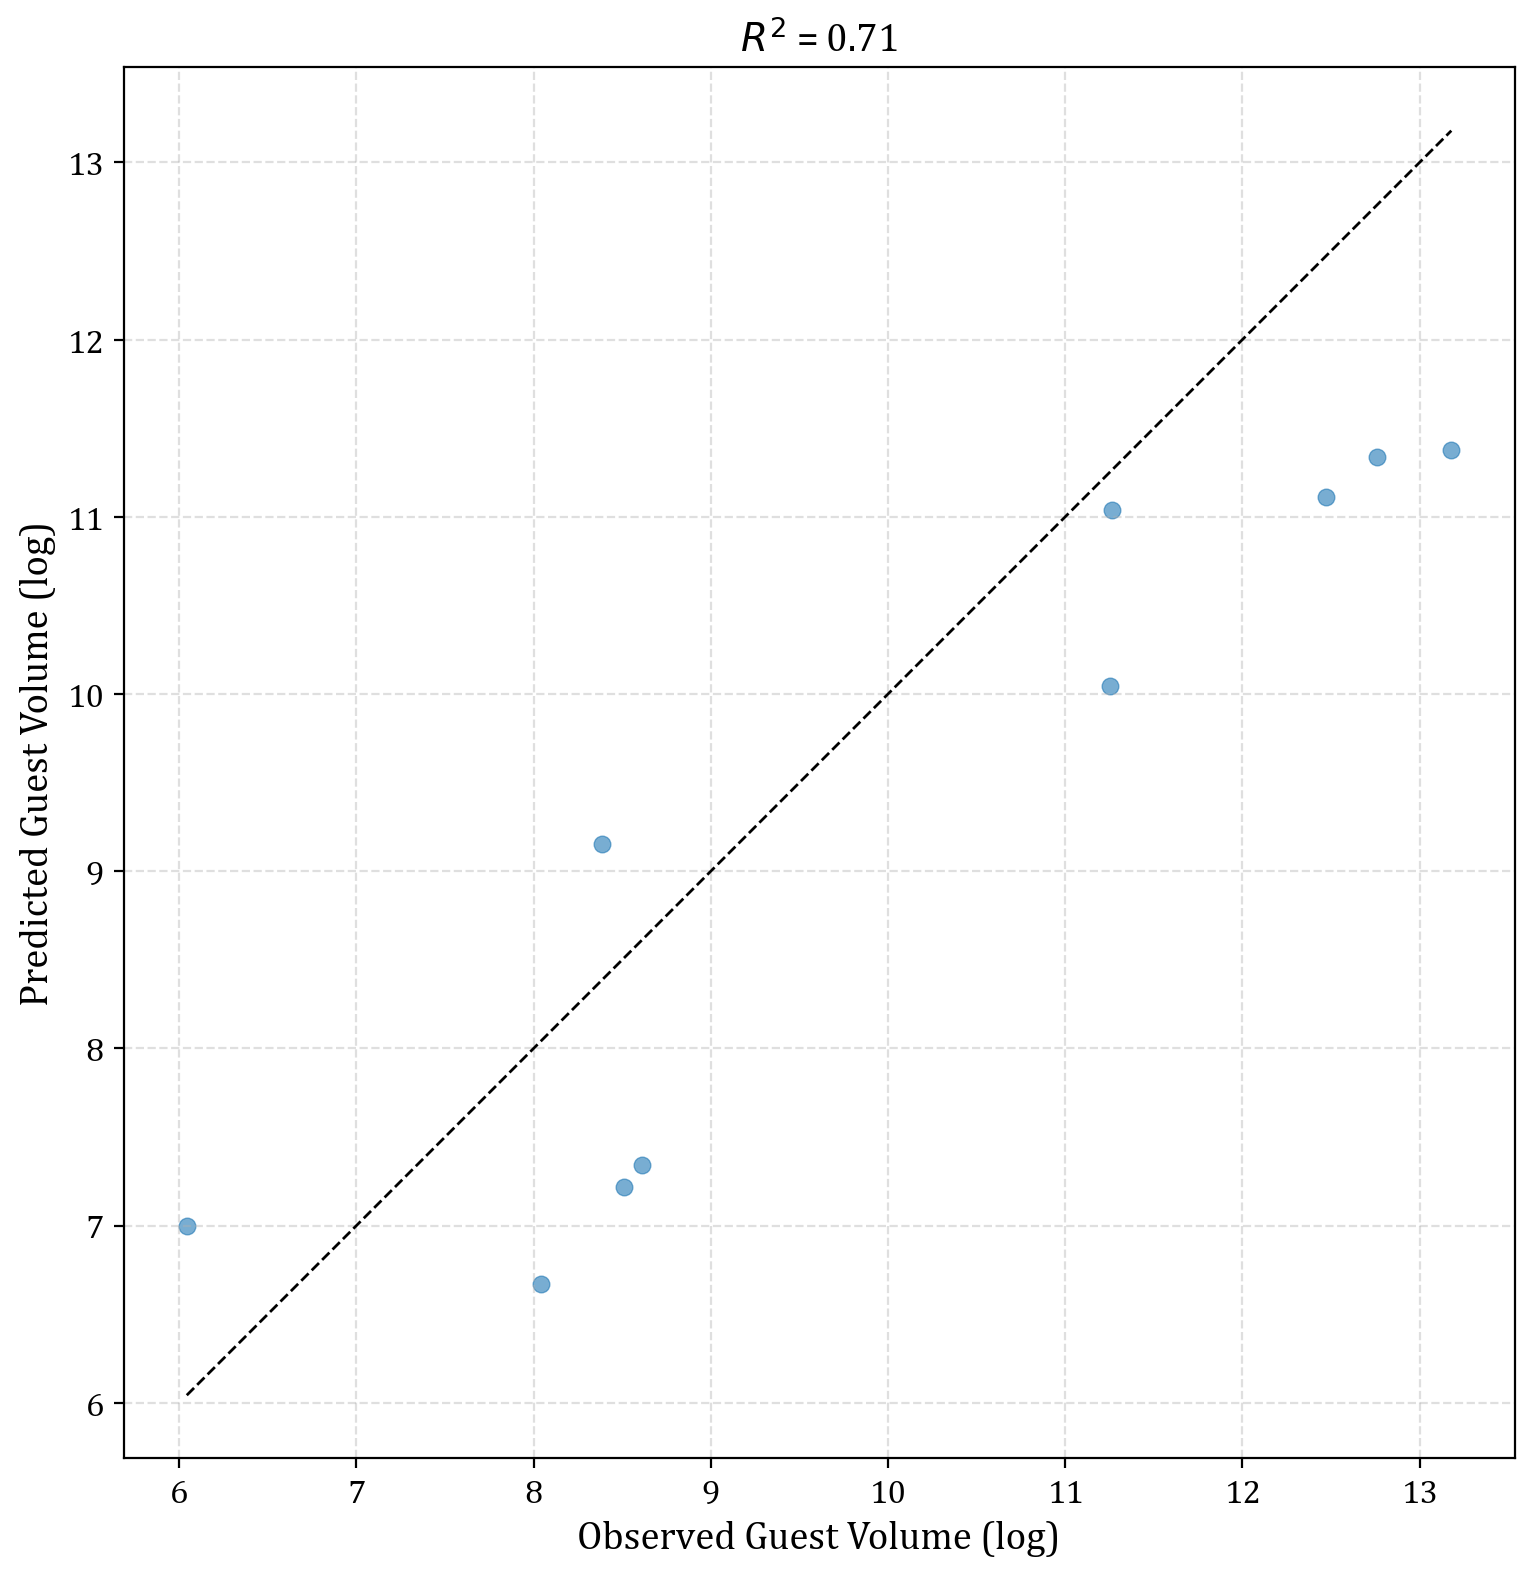

In [23]:
actual_test = np.array(y_test)
predicted_test = np.array(predict_combined)

# R²
r2 = r2_score(actual_test, predicted_test)

plt.figure(figsize=(8, 8))
sns.scatterplot(x=actual_test, y=predicted_test, alpha=0.6, edgecolor=None)

# 1:1 line
lims = [min(actual_test.min(), predicted_test.min()), max(actual_test.max(), predicted_test.max())]
plt.plot(lims, lims, 'k--', linewidth=1)

# Labels and title
plt.xlabel("Observed Guest Volume (log)", fontproperties=cambria_prop, fontsize=14)
plt.ylabel("Predicted Guest Volume (log)", fontproperties=cambria_prop, fontsize=14)
plt.title(f"$R^2$ = {r2:.2f}", fontproperties=cambria_prop, fontsize=14)

# Set tick labels to Cambria
ax = plt.gca()
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(cambria_prop)
    label.set_fontsize(12)

ax.set_aspect('equal', adjustable='box')
ax.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.savefig('../../results/edinburgh/grf_volume_predicted_vs_observed_test.png', dpi=500, bbox_inches='tight')
plt.show()

In [24]:
# Prepare full dataframe
gdf_full = edinburgh_airbnb_tourism_fs.copy()
gdf_full = gdf_full.dropna(subset=['total_volume_log'] + features_logged)

# Extract X, y, and coords
X_full = gdf_full[features_logged]
y_full = gdf_full['total_volume_log']
coords_full = np.array([[geom.centroid.x, geom.centroid.y] for geom in gdf_full.geometry])

# Fit GRF model on ALL data
model_full = PyGRFBuilder(
    n_estimators=750,
    max_features='sqrt',
    band_width=36,  # use your optimal bw
    train_weighted=True,
    predict_weighted=True,
    bootstrap=False,
    resampled=True,
    random_state=42,
    kernel="adaptive"
)

model_full.fit(X_full, y_full, coords_full)

# Get local feature importances
local_importance = model_full.get_local_feature_importance().reset_index(drop=True)

# Attach to gdf and get top predictor
gdf_full = gdf_full.reset_index(drop=True)
gdf_full = pd.concat([gdf_full, local_importance], axis=1)

# Only consider true feature columns (remove any metadata if present)
feature_cols_only = [col for col in local_importance.columns if col in features_logged]

# Compute top predictor
gdf_full['top_predictor'] = local_importance[feature_cols_only].idxmax(axis=1)

/opt/anaconda3/envs/geolytix/lib/python3.12/site-packages/PyGRF/PyGRF.py:319: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  feature_importance_df = pd.concat([feature_importance_df, pd.DataFrame([this_row], columns=column_list)], ignore_index=True)


In [ ]:
# Copy gdf_full into gdf_volume
gdf_volume = gdf_full.copy()

# Strip '_log' suffix from top_predictor to match keys
gdf_volume['top_predictor_stripped'] = gdf_volume['top_predictor'].str.replace('_log', '', regex=False)

# Map each stripped predictor to its high-level POI group
gdf_volume['top_predictor_group'] = gdf_volume['top_predictor_stripped'].map(poi_group_map)

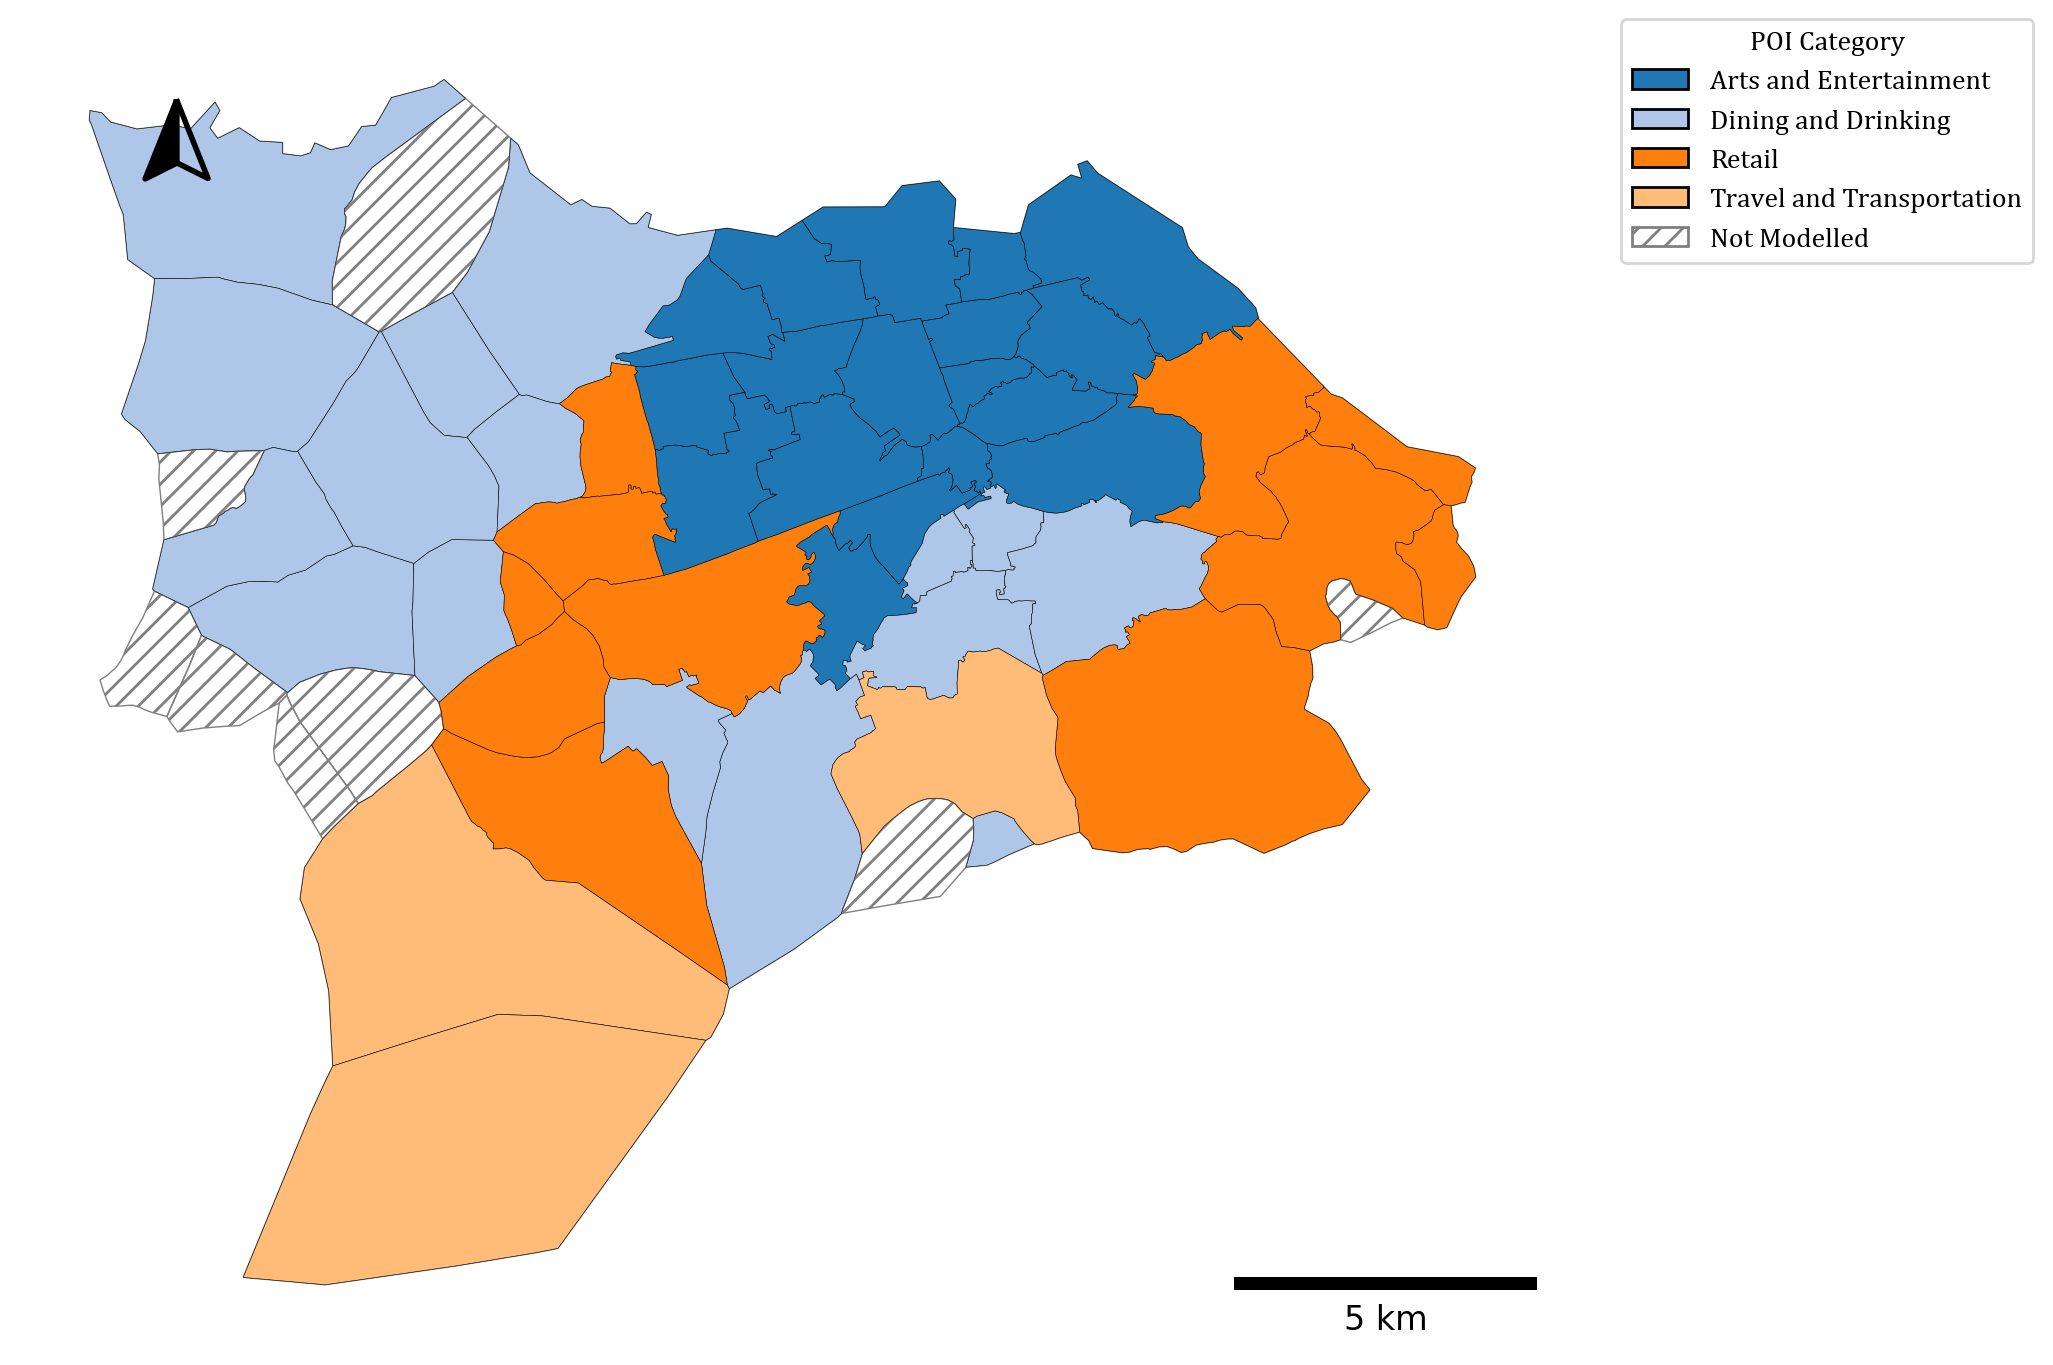

In [ ]:
# Strip '_log' and map to top-level category
gdf_volume['top_predictor_stripped'] = gdf_volume['top_predictor'].str.replace('_log', '', regex=False)
gdf_volume['top_poi_level1'] = gdf_volume['top_predictor_stripped'].map(poi_group_map)

# Get unique categories and assign tab20 colors
unique_pois = sorted(gdf_volume["top_poi_level1"].dropna().unique())
colors = list(plt.cm.tab20.colors)
while len(colors) < len(unique_pois):
    colors += colors  # extend if not enough

poi_color_map = dict(zip(unique_pois, colors[:len(unique_pois)]))

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Plot full base shapefile with hatch for areas not in model
edinburgh_glx.plot(
    ax=ax,
    facecolor="none",
    edgecolor="grey",
    hatch="///",
    linewidth=0.5,
    zorder=0
)

# Plot valid GRF neighbourhoods by POI category
for poi, color in poi_color_map.items():
    subset = gdf_volume[gdf_volume["top_poi_level1"] == poi]
    subset.plot(ax=ax, color=color, edgecolor="black", linewidth=0.2, zorder=1)

# Legend
legend_elements = [
    Patch(facecolor=poi_color_map[poi], edgecolor='black', label=poi)
    for poi in unique_pois
]
# Add legend entry for hatch
legend_elements.append(
    Patch(facecolor='white', edgecolor='gray', hatch='///', label='Not Modelled')
)

legend = ax.legend(
    handles=legend_elements,
    title="POI Category",
    title_fontproperties=cambria_prop,
    prop=cambria_prop,
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    borderaxespad=0.
)

# North arrow & scale bar
#add_north_arrow(ax, scale=0.5, xlim_pos=.1025, ylim_pos=.880, color='#000', text_scaler=0, text_yT=-1.25)

#scalebar = ScaleBar(1, location="lower right", units="m", color="black", font_properties={"size": 12})
#ax.add_artist(scalebar)

# Finalise
ax.axis("off")
plt.tight_layout()
plt.savefig('../../results/edinburgh/grfVolume_broad_poi_map.png', dpi=300, bbox_inches='tight')
plt.show()

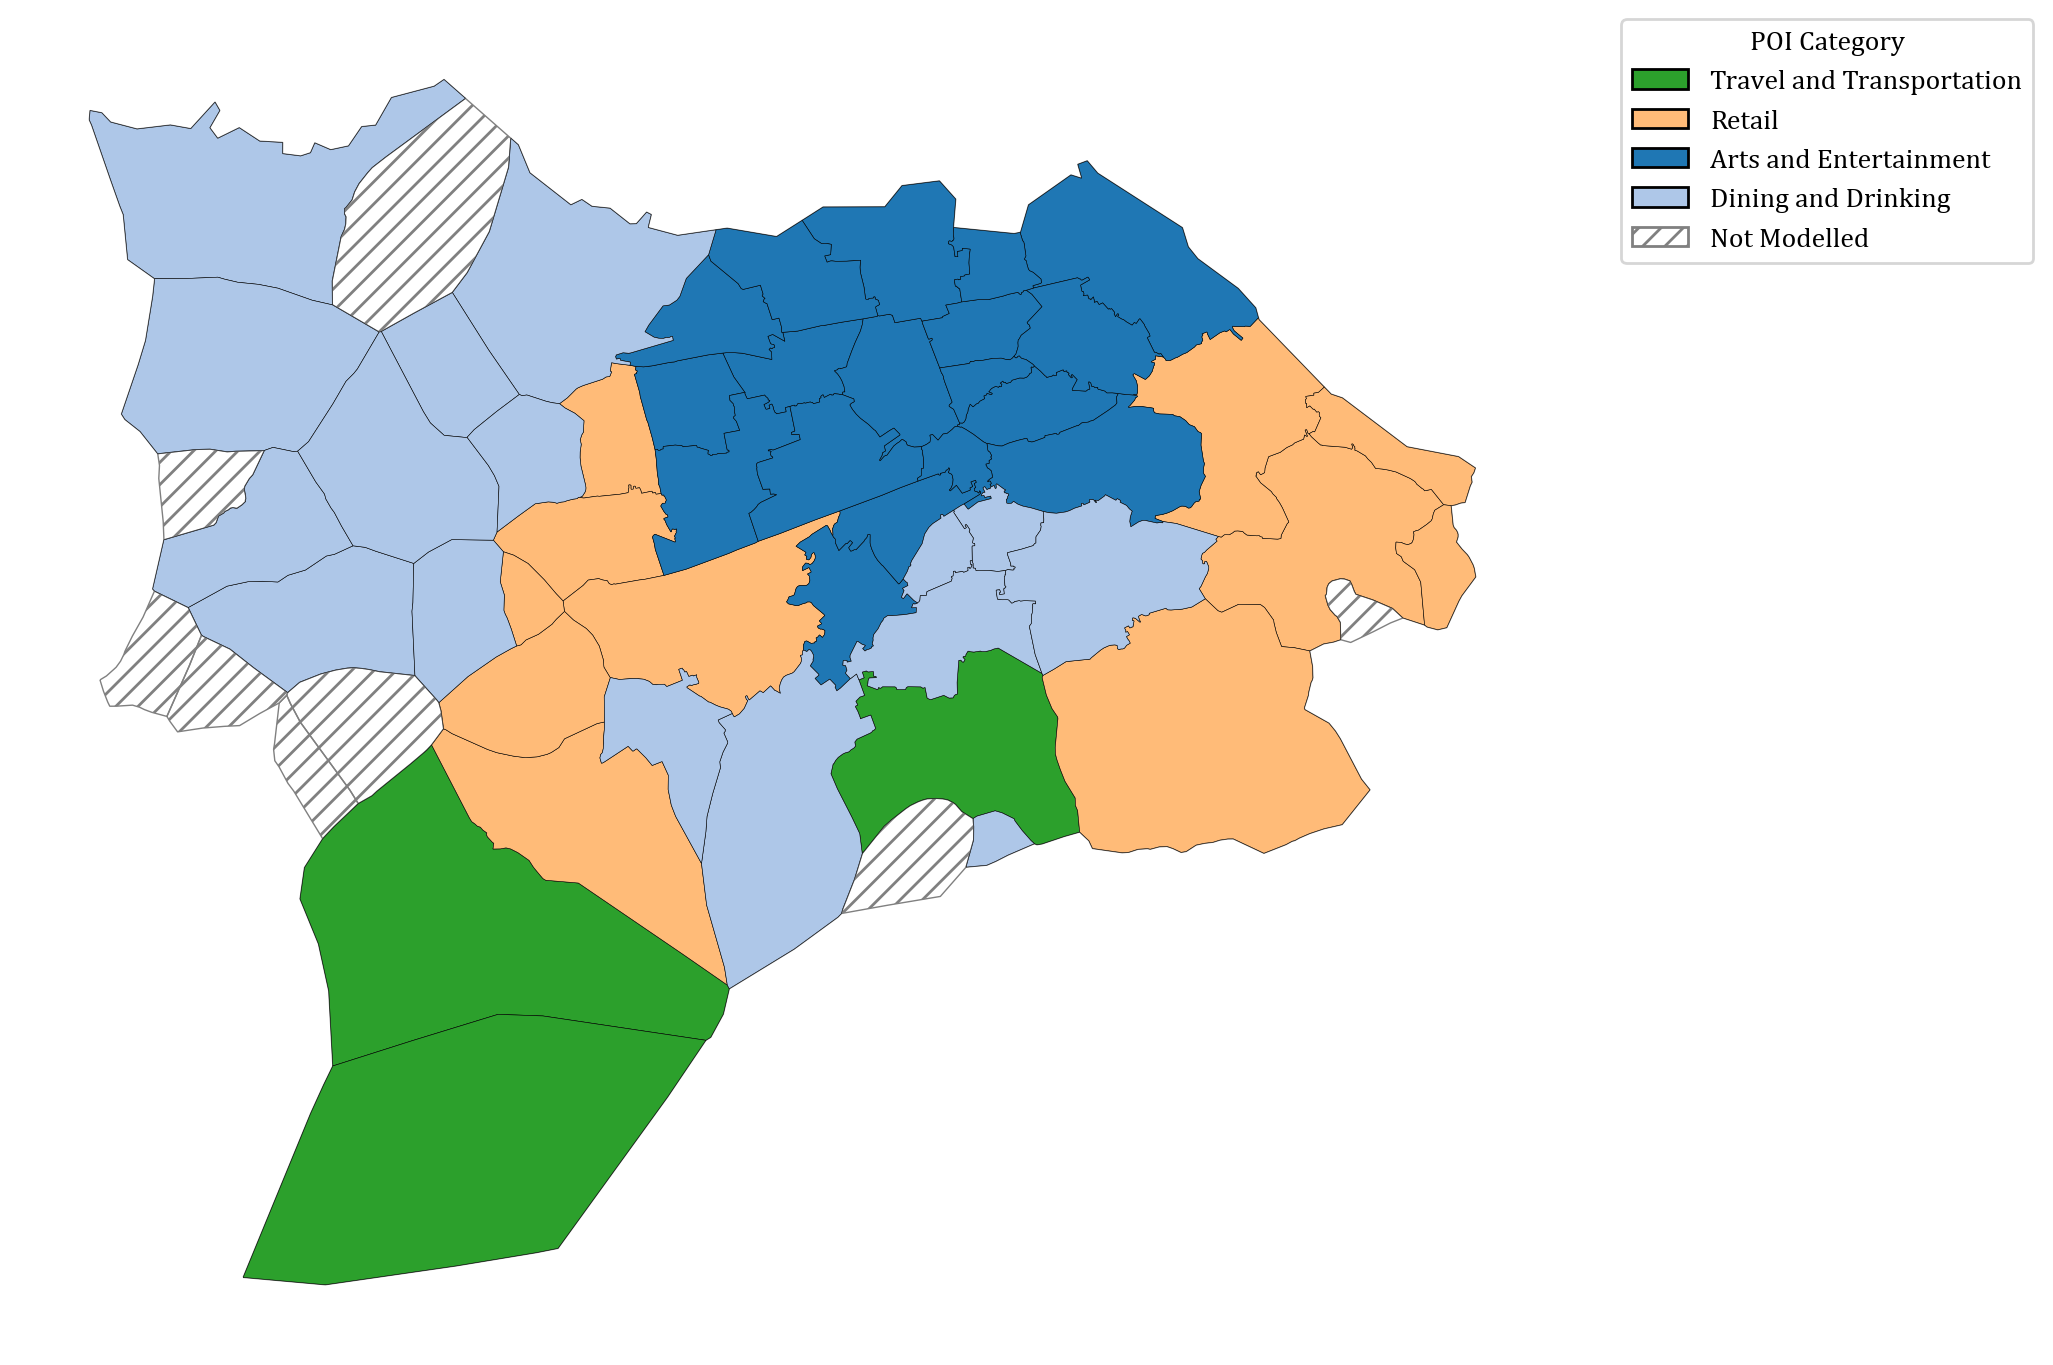

In [35]:
# Apply POI mapping 
gdf_volume['top_predictor_stripped'] = gdf_volume['top_predictor'].str.replace('_log', '', regex=False)
gdf_volume['top_poi_level1'] = gdf_volume['top_predictor_stripped'].map(poi_group_map)

# Create figure 
fig, ax = plt.subplots(figsize=(10, 8))

# Plot base layer with hatch for areas not modelled
edinburgh_glx.plot(
    ax=ax,
    facecolor="none",
    edgecolor="grey",
    hatch="///",
    linewidth=0.5,
    zorder=0
)

# Plot modelled neighbourhoods by top POI category
present_pois = gdf_volume["top_poi_level1"].dropna().unique()

for poi in present_pois:
    if poi in custom_poi_color_map:
        subset = gdf_volume[gdf_volume["top_poi_level1"] == poi]
        subset.plot(
            ax=ax,
            color=custom_poi_color_map[poi],
            edgecolor="black",
            linewidth=0.2,
            zorder=1
        )

# Legend
legend_elements = [
    Patch(facecolor=custom_poi_color_map[poi], edgecolor='black', label=poi)
    for poi in present_pois if poi in custom_poi_color_map
]

# Add hatch legend for non-modelled areas
legend_elements.append(
    Patch(facecolor='white', edgecolor='gray', hatch='///', label='Not Modelled')
)

legend = ax.legend(
    handles=legend_elements,
    title="POI Category",
    title_fontproperties=cambria_prop,
    prop=cambria_prop,
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    borderaxespad=0.
)

# Finalise plot
ax.axis("off")
plt.tight_layout()
plt.savefig('../../results/edinburgh/grfVolume_broad_poi_map.png', dpi=300, bbox_inches='tight')
plt.show()

In [27]:
# Save gdf_volume to file
gdf_volume = gpd.GeoDataFrame(gdf_volume, geometry='geometry')

# Now export only the selected columns
gdf_volume[['glx_id', 'top_predictor', 'top_poi_level1', 'geometry']].to_file(
    '../../data/edinburgh/grfVolume.gpkg',
    driver='GPKG'
)

### Density

In [27]:
# Prepare data
density_grf = edinburgh_airbnb_tourism_fs.copy()

# Filter out missing values
density_grf = density_grf.dropna(subset=['total_tourism_intensity_km2_log'] + features_logged)

# Extract features (X), target (y), and coordinates
X = density_grf[features_logged]
y = density_grf['total_tourism_intensity_km2_log']

# Coordinates from geometry centroids
coords = np.array([[geom.centroid.x, geom.centroid.y] for geom in density_grf.geometry])

# Train/test split (also split the coords)
X_train, X_test, y_train, y_test, coords_train, coords_test = train_test_split(
    X, y, coords, test_size=0.2, random_state=42
)

In [28]:
# Use your training data and coordinates
rev_best_bw = search_bandwidth(
    X_train,
    y_train,
    coords_train,
    bw_min=2,
    bw_max=5,
    step=2,
    n_estimators=500,
    max_features='sqrt',
    train_weighted=True,
    random_state=42
)

print("Best bandwidth:", rev_best_bw)

bandwidth: 2 mixed: 0.9128
bandwidth: 4 mixed: 0.8889
Best Bandwidth:  2.0
Best bandwidth: {'bandwidth_search_result':    bandwidth     mixed
0          2  0.912846
1          4  0.888904, 'best_bandwidth': np.float64(2.0)}


In [29]:
# Create PyGRF model
model = PyGRF.PyGRFBuilder(
    n_estimators=750,
    max_features='sqrt',
    band_width=36,
    train_weighted=True,
    predict_weighted=True,
    bootstrap=True,
    resampled=True,
    random_state=42,
    kernel="adaptive"
)

# Fit the model on training data
print("Fitting model...")
model.fit(X_train, y_train, coords_train)

# Get the local R2 values
density_local_R2 = PyGRFBuilder.get_local_R2(model)

# Predict on test set
predict_combined, predict_global, predict_local = model.predict(
    X_test, coords_test, local_weight=0.46
)

# Evaluate on log scale
r2_combined = r2_score(y_test, predict_combined)
rmse_combined = np.sqrt(mean_squared_error(y_test, predict_combined))
mae_combined = mean_absolute_error(y_test, predict_combined)

# Evaluate on original scale
y_test_exp = np.exp(y_test)
predict_combined_exp = np.exp(predict_combined)

# Evaluate performance
r2_combined = r2_score(y_test, predict_combined)

rmse_combined_exp = np.sqrt(mean_squared_error(y_test_exp, predict_combined_exp))
mae_combined_exp = mean_absolute_error(y_test_exp, predict_combined_exp)

# Print all
print("Combined model R² (log scale):", round(r2_combined, 3))
print("Combined model RMSE (log scale):", round(rmse_combined, 3))
print("Combined model MAE (log scale):", round(mae_combined, 3))

print("Combined model RMSE (original scale):", round(rmse_combined_exp, 2))
print("Combined model MAE (original scale):", round(mae_combined_exp, 2))

Fitting model...


/opt/anaconda3/envs/geolytix/lib/python3.12/site-packages/PyGRF/PyGRF.py:344: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  R2_df = pd.concat([R2_df, pd.DataFrame([this_row], columns=column_list)], ignore_index=True)


Combined model R² (log scale): 0.928
Combined model RMSE (log scale): 0.608
Combined model MAE (log scale): 0.558
Combined model RMSE (original scale): 255.31
Combined model MAE (original scale): 151.48


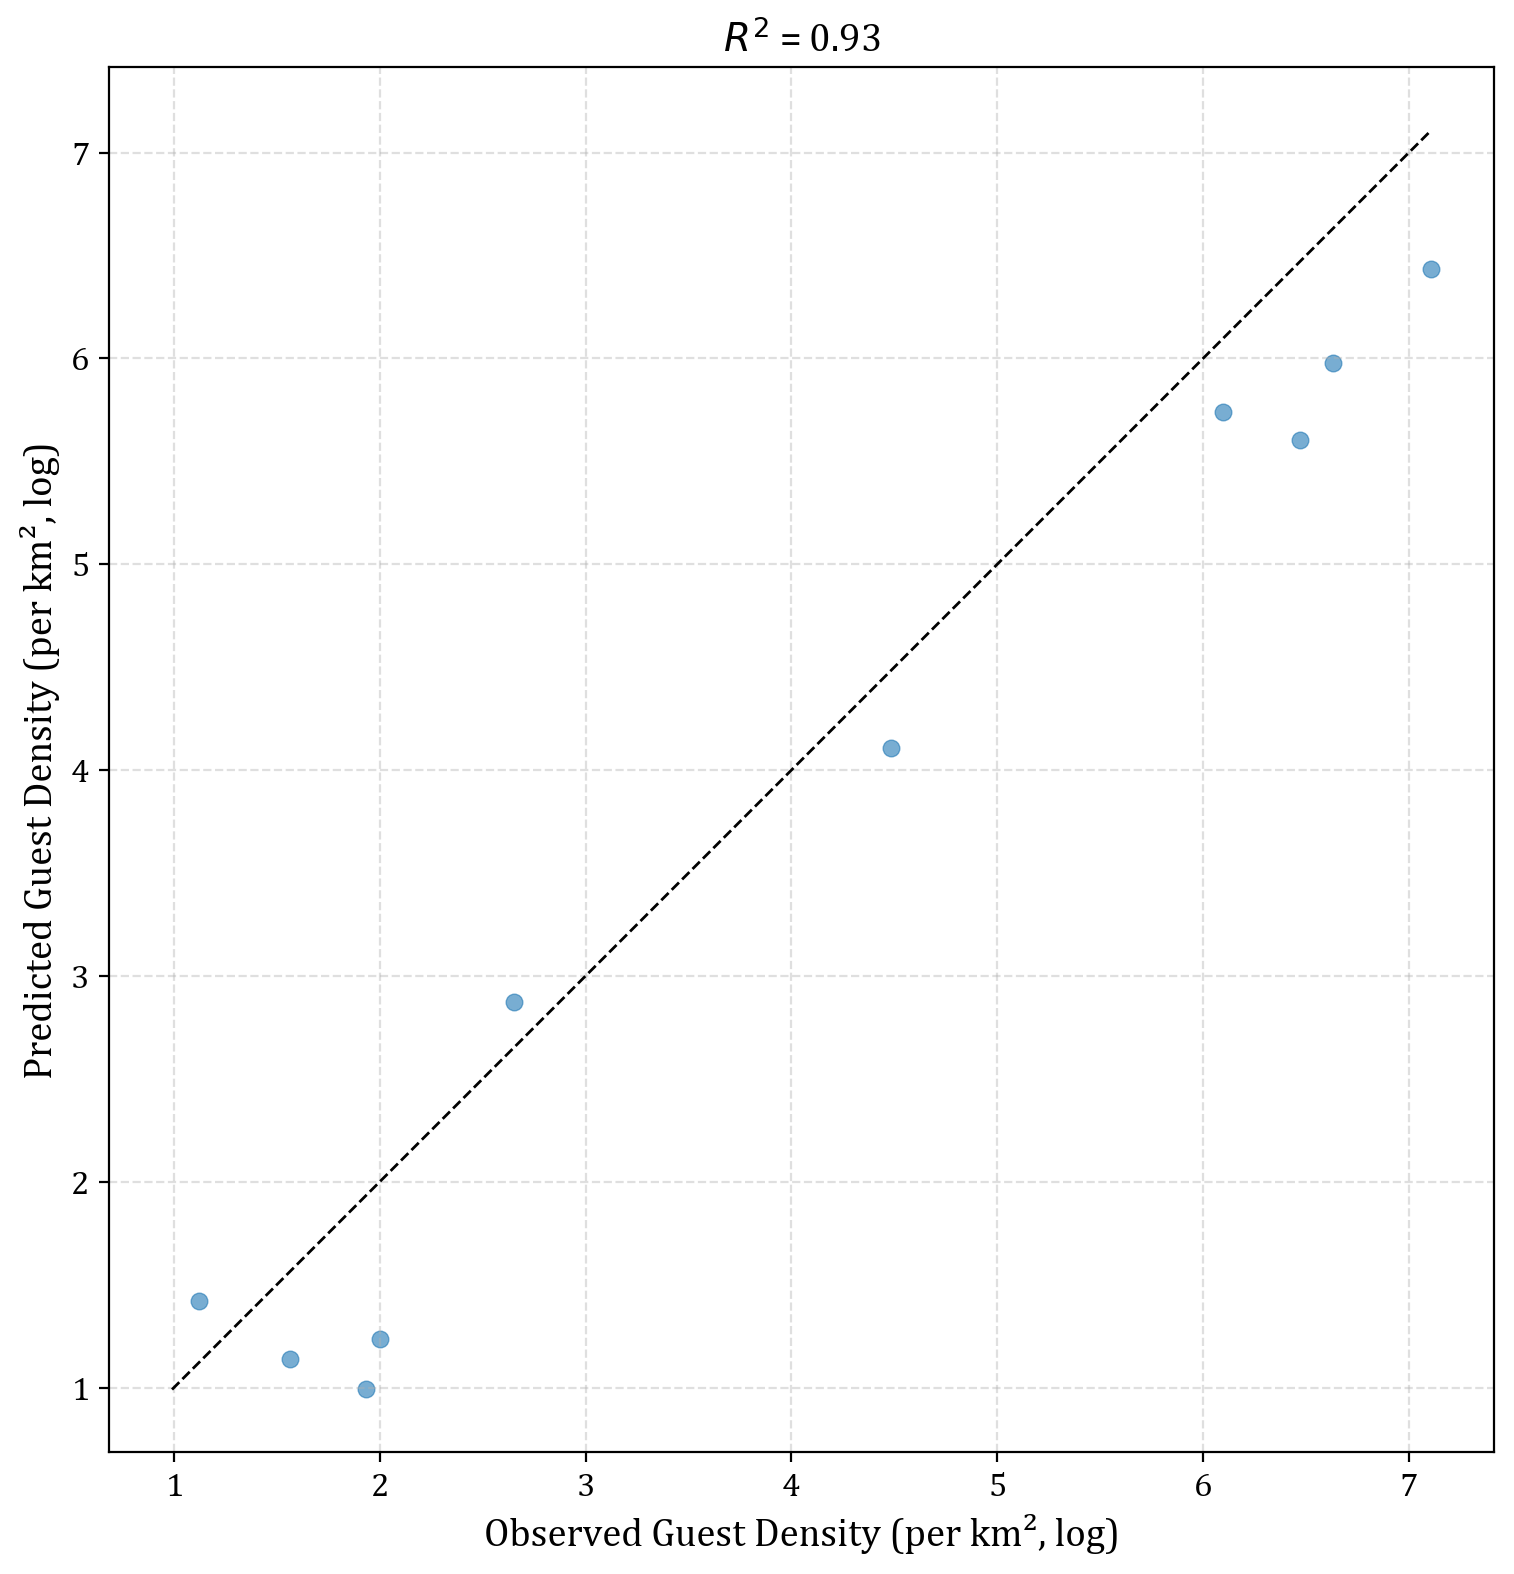

In [30]:
actual_test = np.array(y_test)
predicted_test = np.array(predict_combined)

# R²
r2 = r2_score(actual_test, predicted_test)

plt.figure(figsize=(8, 8))
sns.scatterplot(x=actual_test, y=predicted_test, alpha=0.6, edgecolor=None)

# 1:1 line
lims = [min(actual_test.min(), predicted_test.min()), max(actual_test.max(), predicted_test.max())]
plt.plot(lims, lims, 'k--', linewidth=1)

# Labels and title
plt.xlabel("Observed Guest Density (per km², log)", fontproperties=cambria_prop, fontsize=14)
plt.ylabel("Predicted Guest Density (per km², log)", fontproperties=cambria_prop, fontsize=14)
plt.title(f"$R^2$ = {r2:.2f}", fontproperties=cambria_prop, fontsize=14)

# Set tick labels to Cambria
ax = plt.gca()
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(cambria_prop)
    label.set_fontsize(12)

ax.set_aspect('equal', adjustable='box')
ax.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.savefig('../../results/edinburgh/grf_density_predicted_vs_observed_test.png', dpi=500, bbox_inches='tight')
plt.show()

In [31]:
# Prepare full dataframe
gdf_full = edinburgh_airbnb_tourism_fs.copy()
gdf_full = gdf_full.dropna(subset=['total_tourism_intensity_km2_log'] + features_logged)

# Extract X, y, and coords
X_full = gdf_full[features_logged]
y_full = gdf_full['total_tourism_intensity_km2_log']
coords_full = np.array([[geom.centroid.x, geom.centroid.y] for geom in gdf_full.geometry])

# Fit GRF model on ALL data
model_full = PyGRFBuilder(
    n_estimators=750,
    max_features='sqrt',
    band_width=36,  # use your optimal bw
    train_weighted=True,
    predict_weighted=True,
    bootstrap=False,
    resampled=True,
    random_state=42,
    kernel="adaptive"
)

model_full.fit(X_full, y_full, coords_full)

# Get local feature importances
local_importance = model_full.get_local_feature_importance().reset_index(drop=True)

# Attach to gdf and get top predictor
gdf_full = gdf_full.reset_index(drop=True)
gdf_full = pd.concat([gdf_full, local_importance], axis=1)

# Only consider true feature columns (remove any metadata if present)
feature_cols_only = [col for col in local_importance.columns if col in features_logged]

# Compute top predictor
gdf_full['top_predictor'] = local_importance[feature_cols_only].idxmax(axis=1)

/opt/anaconda3/envs/geolytix/lib/python3.12/site-packages/PyGRF/PyGRF.py:319: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  feature_importance_df = pd.concat([feature_importance_df, pd.DataFrame([this_row], columns=column_list)], ignore_index=True)


In [32]:
# Copy gdf_full into gdf_density
gdf_density = gdf_full.copy()

# STEP 1: Strip '_log' suffix from top_predictor to match keys
gdf_density['top_predictor_stripped'] = gdf_density['top_predictor'].str.replace('_log', '', regex=False)

# STEP 2: Map each stripped predictor to its high-level POI group
gdf_density['top_predictor_group'] = gdf_density['top_predictor_stripped'].map(poi_group_map)

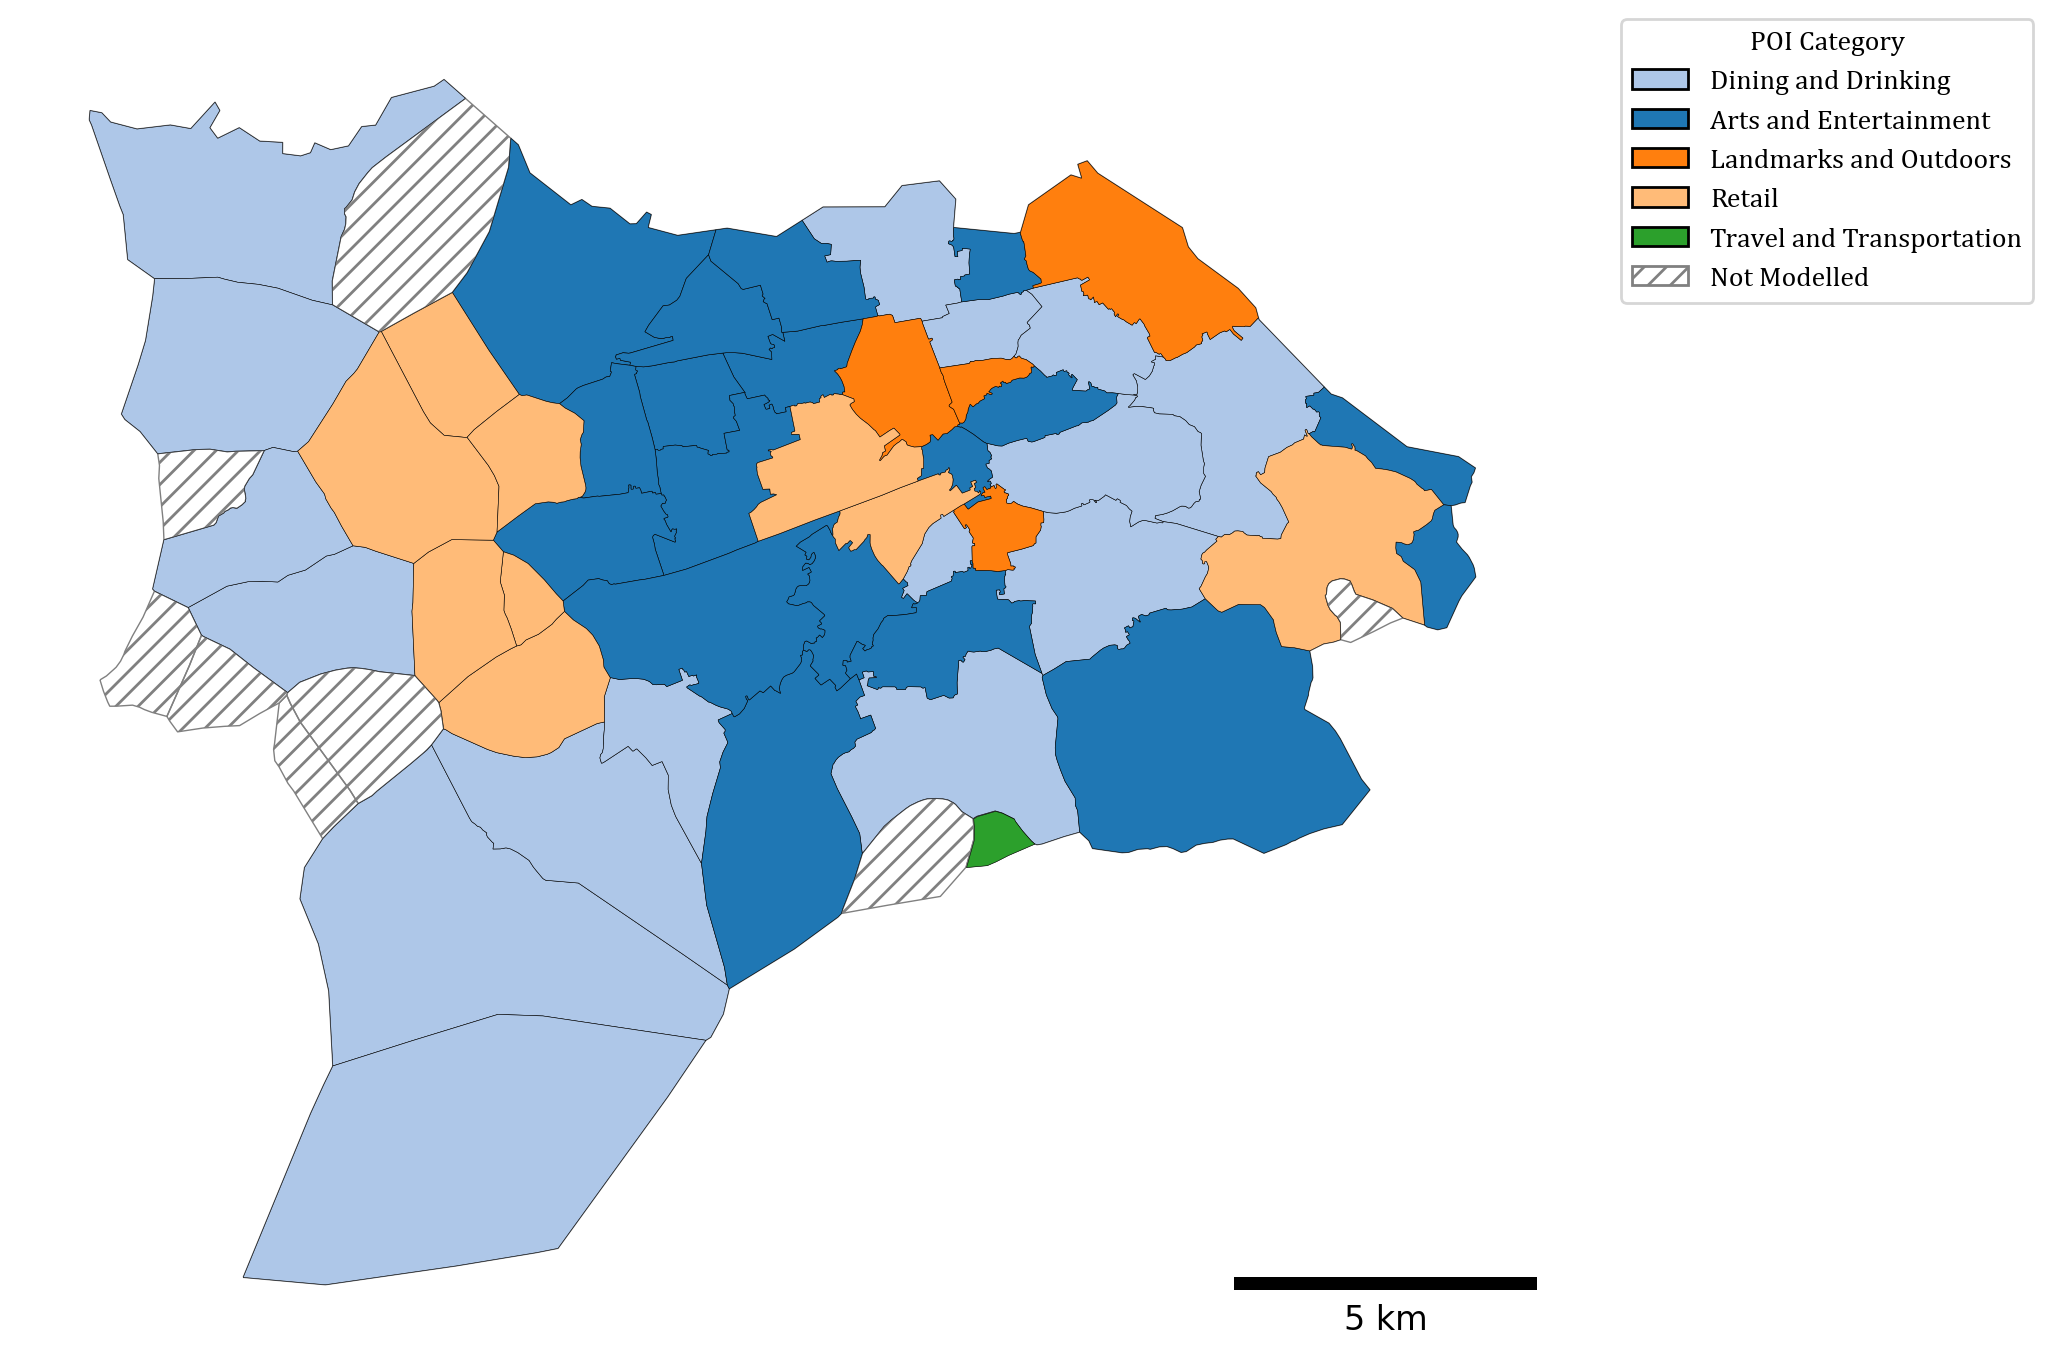

In [37]:
# Apply POI mapping 
gdf_density['top_predictor_stripped'] = gdf_density['top_predictor'].str.replace('_log', '', regex=False)
gdf_density['top_poi_level1'] = gdf_density['top_predictor_stripped'].map(poi_group_map)

# Create figure 
fig, ax = plt.subplots(figsize=(10, 8))

# Plot base layer with hatch for areas not modelled
edinburgh_glx.plot(
    ax=ax,
    facecolor="none",
    edgecolor="grey",
    hatch="///",
    linewidth=0.5,
    zorder=0
)

# Plot modelled neighbourhoods by top POI category
present_pois = gdf_density["top_poi_level1"].dropna().unique()

for poi in present_pois:
    if poi in custom_poi_color_map:
        subset = gdf_density[gdf_density["top_poi_level1"] == poi]
        subset.plot(
            ax=ax,
            color=custom_poi_color_map[poi],
            edgecolor="black",
            linewidth=0.2,
            zorder=1
        )

# Legend
legend_elements = [
    Patch(facecolor=custom_poi_color_map[poi], edgecolor='black', label=poi)
    for poi in present_pois if poi in custom_poi_color_map
]

# Add hatch legend for non-modelled areas
legend_elements.append(
    Patch(facecolor='white', edgecolor='gray', hatch='///', label='Not Modelled')
)

legend = ax.legend(
    handles=legend_elements,
    title="POI Category",
    title_fontproperties=cambria_prop,
    prop=cambria_prop,
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    borderaxespad=0.
)

scalebar = ScaleBar(1, location="lower right", units="m", color="black", font_properties={"size": 12})
ax.add_artist(scalebar)

# Finalise plot
ax.axis("off")
plt.tight_layout()
plt.savefig('../../results/edinburgh/grfDensity_broad_poi_map.png', dpi=500, bbox_inches='tight')
plt.show()

In [66]:
# Save gdf_density to file
gdf_density = gpd.GeoDataFrame(gdf_density, geometry='geometry')

# Now export only the selected columns
gdf_density[['glx_id', 'top_predictor', 'top_poi_level1', 'geometry']].to_file(
    '../../data/edinburgh/grfDensity.gpkg',
    driver='GPKG'
)